In [2]:
import torch
import dgl.nn as dglnn
from dgl import from_networkx
from dgl import save_graphs, load_graphs
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
from sklearn.utils import class_weight
import timeit

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load NF-Bot IoT Dataset

In [2]:
# Load NF-Bot IoT Dataset
# data = pd.read_csv('/content/sample_data/NF-BoT-IoT.csv')
data = pd.read_csv('/scratch/kc01/na3038/NF-BoT-IoT.csv')
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/NF-BoT-IoT.csv')
# if need to concat Dos and DDos
data['Attack'] = data['Attack'].replace('DDoS', 'DoS/DDoS')
data['Attack'] = data['Attack'].replace('DoS', 'DoS/DDoS')
data['Attack'].unique()

#test
# data_unknown = data[data['Attack'] == 'Reconnaissance']
# data = data[data['Attack'] != 'Benign']

#Other data processings
# data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
data.drop(columns=['Label'],inplace = True)
data.rename(columns={"Attack": "label"},inplace = True)

le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])
label = data.label

data.drop(columns=['label'],inplace = True)
data =  pd.concat([data, label], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3) # random_state=123

encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
scaler = StandardScaler()
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [3]:
# joblib.dump(le, "/scratch/kc01/na3038/TrainedModels/label_encoder.pkl")
le = joblib.load("/scratch/kc01/na3038/TrainedModels/label_encoder.pkl")

In [4]:
X_test = encoder.transform(X_test)
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])
X_test['Edge_indx'] = list(range(len(X_test.values)))

X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [5]:
# X_recon = X_test[X_test['label']==2]
# X_recon
# X_recon[X_recon['IPV4_SRC_ADDR']=='172.18.89.130:4085']
X_test.head()

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,Edge_indx,h
80765,192.168.100.148:33844,192.168.100.6:32775,0.257418,0.564689,-0.020897,-0.008970,-0.046177,-0.027158,0.677062,0.496198,2,0,"[-0.0461766280133901, 0.49619793628766384, 0.6..."
107503,192.168.100.148:37557,192.168.100.3:2602,0.257418,0.564689,-0.020897,-0.008970,-0.046177,-0.027158,0.677062,0.496198,2,1,"[-0.0461766280133901, 0.49619793628766384, 0.6..."
101409,192.168.100.150:55197,192.168.100.6:8292,0.257418,0.564689,-0.020897,-0.008970,-0.046177,-0.027158,0.677062,0.496198,2,2,"[-0.0461766280133901, 0.49619793628766384, 0.6..."
233258,192.168.100.148:33133,192.168.100.7:8022,0.257418,0.564689,-0.020897,-0.008970,-0.046177,-0.027158,0.677062,0.496197,2,3,"[-0.0461766280133901, 0.4961973359546787, 0.67..."
456425,192.168.100.150:51726,192.168.100.3:3306,0.257418,0.564689,-0.019987,-0.008279,-0.021938,0.002573,-1.386678,0.496078,2,4,"[-0.02193827058130118, 0.49607847002361544, -1..."


In [4]:
cols_to_norm =['IN_PKTS',
 'FLOW_DURATION_MILLISECONDS',
 'TCP_FLAGS',
 'L7_PROTO',
 'OUT_PKTS',
 'IN_BYTES',
 'PROTOCOL',
 'OUT_BYTES']
# ['IN_PKTS',
#  'L7_PROTO',
#  'TCP_FLAGS',
#  'PROTOCOL',
#  'IN_BYTES',
#  'OUT_BYTES',
#  'FLOW_DURATION_MILLISECONDS',
#  'OUT_PKTS']
# =['TCP_FLAGS',
#  'OUT_BYTES',
#  'OUT_PKTS',
#  'L7_PROTO',
#  'PROTOCOL',
#  'IN_PKTS',
#  'FLOW_DURATION_MILLISECONDS',
#  'IN_BYTES']
# =['IN_BYTES',
#  'PROTOCOL',
#  'L7_PROTO',
#  'TCP_FLAGS',
#  'OUT_BYTES',
#  'OUT_PKTS',
#  'FLOW_DURATION_MILLISECONDS',
#  'IN_PKTS']

In [5]:
number_of_classes = 4

# Generate Graphs for train and test

In [9]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G,edge_attrs=['h','label'] )
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))
G = G.to('cuda')

In [71]:
# save_graphs("/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/graph.dgl", G)
file_path = "/scratch/kc01/na3038/TrainedModels/graph.dgl"
# save_graphs(file_path, G)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G)
G = G.to('cuda')

Graph(num_nodes=66418, num_edges=840127,
      ndata_schemes={'h': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32)})


In [14]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label','Edge_indx'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label','Edge_indx'] )

actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))
G_test = G_test.to('cuda')

In [30]:
# save_graphs("/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/graph_test.dgl", G_test)
file_path = "/scratch/kc01/na3038/TrainedModels/graph_test.dgl"
# save_graphs(file_path, G_test)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G_test = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G_test)
G_test = G_test.to('cuda')

Graph(num_nodes=44557, num_edges=360051,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32)})


In [72]:
file_path = "/scratch/kc01/na3038/TrainedModels/graph_test_labled.dgl"
# save_graphs(file_path, G_test)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G_test = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G_test)
G_test = G_test.to('cuda')

Graph(num_nodes=44557, num_edges=360051,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32)})


In [44]:
file_path = "/scratch/kc01/na3038/TrainedModels/actual.npy"
# np.save(file_path, actual)

# Load the graph
loaded_array = np.load(file_path, allow_pickle=True)
actual = th.from_numpy(loaded_array)
actual = le.inverse_transform(actual)
print(actual)

['Reconnaissance' 'Reconnaissance' 'Reconnaissance' ... 'Reconnaissance'
 'DoS/DDoS' 'DoS/DDoS']


# Detection

In [67]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        # global emb
        # emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, number_of_classes)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None, embed=False):
      if edge_weight != None:
        #apply eweight one edges
        efe = []
        for i, x in enumerate(edge_weight):
          efe.append(list(th.Tensor.cpu(G.edata['h'][i][0]).detach().numpy()*th.Tensor.cpu(x).detach().numpy()))
        efe = th.FloatTensor(efe).cuda()
        efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
        g.edata['h'] = efe = efe
      if feature_weight != None:
          efe= []
          weights = th.tensor(feature_weight,device='cuda')
          # weights = weights.view(1, 1, -1)
          g.edata['h'] *= weights
          efe = g.edata['h']
          g.edata['h'] = efe = efe
      h = self.gnn(g, nfeats,efeats)
      if embed:
        return h
      else:
        return self.pred(g, h)

/jobfs/145254684.gadi-pbs/ipykernel_1803928/1470260514.py:21: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/jobfs/145254684.gadi-pbs/ipykernel_1803928/1470260514.py:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.8443675637245178
Training acc: 0.8592212796211243
Training acc: 0.7426115274429321
Training acc: 0.8624398112297058
Training acc: 0.7115566730499268
Training acc: 0.869178056716919
Training acc: 0.8691530823707581
Training acc: 0.8768971562385559
Training acc: 0.8731203675270081
Training acc: 0.876788854598999
Training acc: 0.8717871904373169
Training acc: 0.8755794763565063
Training acc: 0.8751533627510071
Training acc: 0.8720585703849792
Training acc: 0.8743951320648193
Training acc: 0.8757556676864624
Training acc: 0.8759984970092773
Training acc: 0.8743868470191956
Training acc: 0.8787980675697327
Training acc: 0.8760282397270203
Training acc: 0.8746820092201233
Training acc: 0.8755092620849609
Training acc: 0.8783290982246399
Training acc: 0.8765329122543335
Training acc: 0.8780660033226013
Training acc: 0.8775196671485901
Training acc: 0.8739464282989502
Training acc: 0.8784124255180359
Training acc: 0.8773244619369507
356.08600891404785 seconds


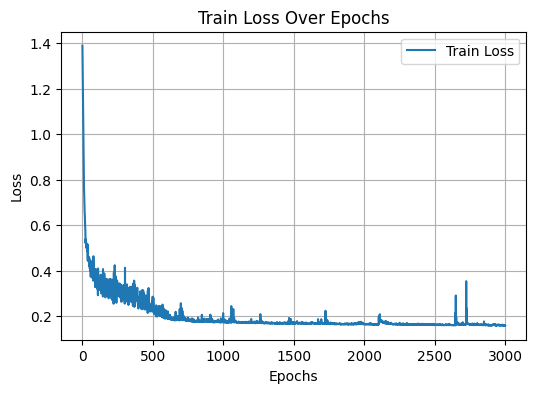

In [18]:
class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

train_losses = []
for epoch in range(1,3000):
    pred = model(G, nfeats, efeats).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    train_losses.append(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

train_losses =  [tensor.cpu().detach().numpy() for tensor in train_losses]
elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

epochs = range(1, 3000)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Save Model

In [19]:
th.save(model, "/scratch/kc01/na3038/TrainedModels/model_state.pth")

In [68]:
def load_checkpoint(filepath):
  checkpoint = th.load(filepath, map_location='cuda')
  model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2)
  model.load_state_dict(checkpoint['state_dict'])
  return model

In [69]:
model = th.load("/scratch/kc01/na3038/TrainedModels/model_state.pth")
print(model)

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=16, out_features=128, bias=True)
        (W_apply): Linear(in_features=136, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=136, out_features=128, bias=True)
        (W_apply): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [70]:
model = model.to('cuda')

In [23]:
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + ' seconds')

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

# actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)


# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, test_pred, output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

0.014966114889830351 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.2524    0.8582    0.3901    0.8582    8185      
DoS/DDoS       0.7815    0.9794    0.8693    0.9794    67978     
Reconnaissance 0.9936    0.8584    0.9211    0.8584    282778    
Theft          0.2995    0.7315    0.4250    0.7315    1110      

Overall Accuracy:
Accuracy: 0.8809

Weighted Averages:
{'precision': 0.9345463099505048, 'recall': 0.8808835414982877, 'f1-score': 0.89770795496148, 'support': 360051.0}


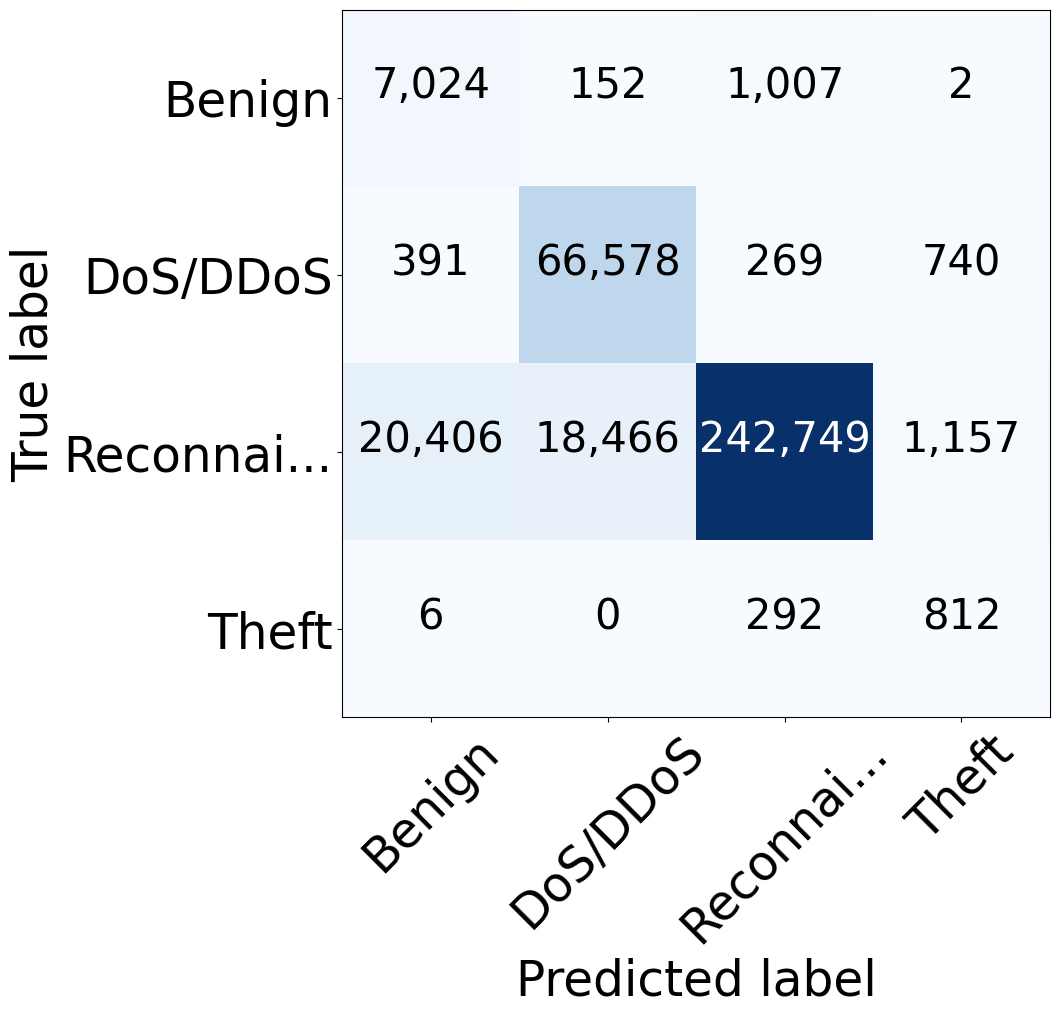

In [24]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=35,
                          text_fontsize=30):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8.5, 8.5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.savefig('/scratch/kc01/na3038/TrainedModels/baseline-cm.png',bbox_inches='tight')
    plt.show()
    
max_label_len = 8  # adjust as needed
target_names = np.unique(actual)
truncated_target_names = [
    f"{label[:max_label_len]}..." if len(label) > max_label_len else label
    for label in target_names
]
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = truncated_target_names,
                      # title        = "Confusion Matrix"
                      )

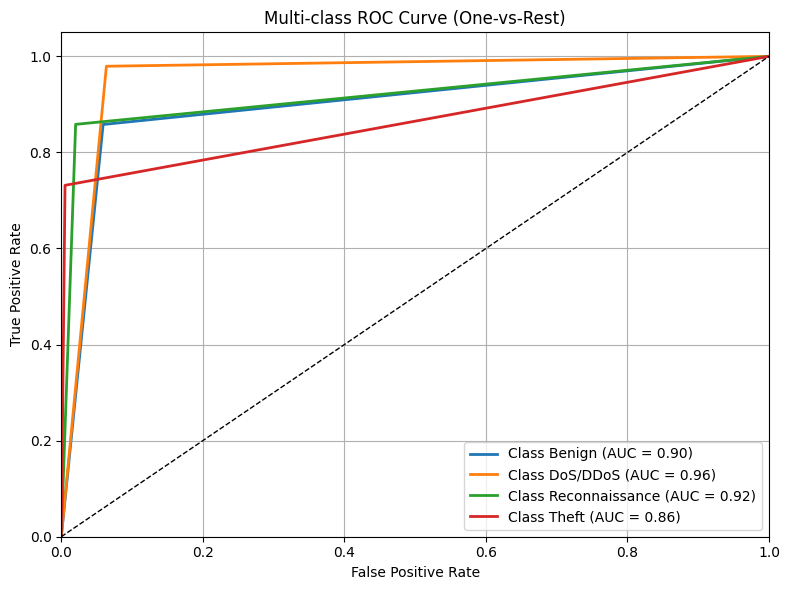

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load example dataset
X = actual
y = test_pred
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 0.011294623836874962 seconds - without randomized source IPS
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.2689    0.8546    0.4091    0.8546    8354      
# DoS            0.7825    0.9695    0.8660    0.9695    68468     
# Reconnaissance 0.9930    0.8632    0.9236    0.8632    282026    
# Theft          0.2551    0.7471    0.3803    0.7471    1202      

# Overall Accuracy:
# Accuracy: 0.8828

# Weighted Averages:
# {'precision': 0.9337421989219714, 'recall': 0.8828218303013471, 'f1-score': 0.8988798792901675, 'support': 360050.0}

In [ ]:
## Save TPs for use in XAI

In [26]:
true_positives = {}
for i in range(len(actual)):
    if test_pred[i] == actual[i]:
      # key = G_test.edata['label'][i].cpu().item()
      key = actual[i]
      if key not in true_positives:
          true_positives[key] = []
      true_positives[key].append(G_test.edata['Edge_indx'][i].cpu().item())

In [49]:
import pickle

file_path = '/scratch/kc01/na3038/TrainedModels/true_positives_sample.pkl'

# with open(file_path, 'wb') as f:
#     pickle.dump(true_positives, f)
# print(f"True positives saved to {file_path}")

In [50]:
with open(file_path, 'rb') as f:
    true_positives = pickle.load(f)

# true_positives

In [29]:
len(true_positives['Reconnaissance'])

242749

In [32]:
min_count=20000
e=0
edges_to_explain=random.sample(true_positives['Reconnaissance'], 5000)#[:5]
for x in edges_to_explain:
    indx_to_explain = (G_test.edata['Edge_indx'] == x).nonzero(as_tuple=True)[0][0].item()
    # print('indx_to_explain',indx_to_explain)
    source_node = th.Tensor.cpu(G_test.edges()[0][int(indx_to_explain)]).detach().numpy()
    # print('source_node',source_node)
    sg, inverse_indices = khop_out_subgraph(G_test, source_node, 2)
    edge_count = sg.num_edges()
    if 50<edge_count<min_count:
        min_count=edge_count
        e=x
print(min_count,e)

52 69467


In [33]:
indx_to_explain = (G_test.edata['Edge_indx'] == 69467).nonzero(as_tuple=True)[0][0].item()
source_node = th.Tensor.cpu(G_test.edges()[0][int(indx_to_explain)]).detach().numpy()
khop_out_subgraph(G_test, source_node, 2)

(Graph(num_nodes=27, num_edges=52,
       ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([5], device='cuda:0'))

In [100]:
indx_to_explain = (G_test.edata['Edge_indx'] == 4).nonzero(as_tuple=True)[0][0].item()
source_node = th.Tensor.cpu(G_test.edges()[0][int(indx_to_explain)]).detach().numpy()
khop_out_subgraph(G_test, source_node, 2)

(Graph(num_nodes=19008, num_edges=61194,
       ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([17785], device='cuda:0'))

# E-PGExplainer

In [61]:
import torch
from math import sqrt
import math
from tqdm import tqdm
from dgl import EID,NID,khop_out_subgraph, khop_in_subgraph, batch
from torch.optim import Adam

import torch.nn as nn

In [62]:
class ExplainerModel(nn.Module):
    def __init__(self):
        super(ExplainerModel, self).__init__()
        self.elayers = nn.Sequential(
            # nn.Linear(256, 128),
            # nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        )

    def forward(self, x):
        x = self.elayers(x)
        x = x.mean(dim=0)
        return x

In [63]:
def generate_computation_graph(graph,edge_id):
    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)

    return sg,inverse_indices

def create_explainer_input(pair, embeds):
        rows = pair[0]
        cols = pair[1]
        row_embeds = embeds[rows]
        col_embeds = embeds[cols]
        input_expl = th.cat([row_embeds, col_embeds], 1)
        return input_expl

In [64]:
#Updated Version
class PGExplainer(nn.Module):
    def __init__(self,model,num_hops=None,explain_graph=True,coff_budget=0.01, coff_connect=5e-4,sample_bias=0.0,):
      super(PGExplainer, self).__init__()
      self.elayers  = ExplainerModel()
      self.model = model
      self.graph_explanation = explain_graph
      self.num_hops = num_hops

      # training hyperparameters for PGExplainer
      self.coff_budget = coff_budget
      self.coff_connect = coff_connect
      self.sample_bias = sample_bias
      self.init_bias = 0.0

    def set_masks(self, graph, edge_mask=None):
        if edge_mask is None:
            num_nodes = graph.num_nodes()
            num_edges = graph.num_edges()

            init_bias = self.init_bias
            std = nn.init.calculate_gain("relu") * math.sqrt(
                2.0 / (2 * num_nodes)
            )
            self.edge_mask = torch.randn(num_edges) * std + init_bias
        else:
            self.edge_mask = edge_mask

        self.edge_mask = self.edge_mask.to(graph.device)

    def clear_masks(self):
        self.edge_mask = None
    def concrete_sample(self, w, beta, training=True):
          if training:
              bias = self.sample_bias
              random_noise = torch.rand(w.size()).to(w.device)
              random_noise = bias + (1 - 2 * bias) * random_noise
              gate_inputs = torch.log(random_noise) - torch.log(
                  1.0 - random_noise
              )
              gate_inputs = (gate_inputs + w) / beta
              gate_inputs = torch.sigmoid(gate_inputs)
          else:
              gate_inputs = torch.sigmoid(w)

          return gate_inputs

    def loss(self, prob, ori_pred):
        target_prob = prob.gather(-1, ori_pred.unsqueeze(-1))
        # 1e-6 added to prob to avoid taking the logarithm of zero
        target_prob += 1e-6
        # computing the log likelihood for a single prediction
        pred_loss = torch.mean(-torch.log(target_prob))

        # size
        edge_mask = self.sparse_mask_values
        if self.coff_budget <= 0:
            size_loss = self.coff_budget * torch.sum(edge_mask)
        else:
            size_loss = self.coff_budget * F.relu(
                torch.sum(edge_mask) - self.coff_budget
            )

        # entropy
        scale = 0.99
        edge_mask = self.edge_mask * (2 * scale - 1.0) + (1.0 - scale)
        mask_ent = -edge_mask * torch.log(edge_mask) - (
            1 - edge_mask
        ) * torch.log(1 - edge_mask)
        mask_ent_loss = self.coff_connect * torch.mean(mask_ent)

        loss = pred_loss + size_loss + mask_ent_loss
        return loss

    def train_step_node(self, edges, graph, temperature, **kwargs):
          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          prob, _, batched_graph, inverse_indices = self.explain_node(
              edges, graph, temperature, training=True, **kwargs
          )

          pred = self.model(
              batched_graph, self.batched_feats,self.batched_efeats, **kwargs
          )
          pred = pred.argmax(-1).data

          loss = self.loss(prob[inverse_indices], pred[inverse_indices])

          del batched_graph,_, inverse_indices,prob, pred

          torch.cuda.empty_cache()

          return loss

    def explain_node(self, edges, graph, temperature=1.0, training=False, **kwargs):
          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if training:
              self.elayers.train()
          else:
              self.elayers.eval()

          self.model.eval()

          batched_graph = []
          batched_embed = []
          for edge_id in edges:
              sg, inverse_indices =  generate_computation_graph(graph, edge_id)
              sg.ndata["feat"]= features[sg.ndata[NID].long()]
              sg.edata["feat"]= edge_features[sg.edata[EID].long()]
              # feats = features[sg.ndata[NID].long()]
              # efeats = edge_features[sg.edata[EID].long()]
              sg.edata["train"] = torch.tensor(
                [eid in inverse_indices for eid in sg.edges(form='eid')], device=sg.device
              )

              embed = self.model(sg, sg.ndata["feat"],sg.edata["feat"],embed=True)
              embed = embed.data
              col, row = sg.edges()
              col_emb = embed[col.long()]
              row_emb = embed[row.long()]
              # self_emb = embed[inverse_indices[0]].repeat(sg.num_edges(), 1)
              # need to concat these if considering combine node-based edge embeddings with raw edge features
              # emb = torch.cat([col_emb, row_emb], dim=-1)
              # emb = create_explainer_input(sg.edges(), embeds) # i think not needed because we do not consider on node embeddings
              batched_embed.append(embed)
              batched_graph.append(sg)
              # print("train step edge:",edge_id)

          batched_graph = batch(batched_graph)

          batched_embed = torch.cat(batched_embed)
          batched_embed = self.elayers(batched_embed) #1,8
          values = batched_embed.reshape(-1) # 8
          values = self.concrete_sample(
              values, beta=temperature, training=training
          )
          self.sparse_mask_values = values

          # col, row = batched_graph.edges()
          # reverse_eids = batched_graph.edge_ids(row, col).long()
          # edge_mask = (values + values[reverse_eids]) / 2
          # todo
          edge_mask = values

          self.set_masks(batched_graph, edge_mask)

          batched_feats = batched_graph.ndata['feat']
          batched_efeats = batched_graph.edata['h']
          # the model prediction with the updated edge mask
          logits = self.model(
              batched_graph, batched_feats, batched_efeats, feature_weight=self.edge_mask, **kwargs
          )
          probs = F.softmax(logits, dim=-1)
          # print(probs.shape)

          batched_inverse_indices = (
              batched_graph.edata["train"].nonzero().squeeze(1)
          )

          if training:
              self.batched_feats = batched_feats
              self.batched_efeats = batched_efeats
              probs = probs.data
          else:
              self.clear_masks()

          del batched_feats, batched_efeats, logits
          torch.cuda.empty_cache()
          return (
              probs,
              edge_mask,
              batched_graph,
              batched_inverse_indices,
          )

In [65]:
features = G_test.ndata['feature']
edge_features = G_test.edata['h']
labels = G_test.edata['label']

In [41]:
torch.cuda.empty_cache()

In [42]:
true_positives.keys()

dict_keys(['Reconnaissance', 'DoS/DDoS', 'Benign', 'Theft'])

In [43]:
final_features ={key: [] for key in range(4)} 
final_scores = {k: {} for k in true_positives.keys()} #dict.fromkeys(true_positives.keys(), {})
for attack in true_positives.keys():  # ['Reconnaissance']true_positives.keys()[:1]: #['Theft']: #
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:50] # select 50 random edges from train data for each attack

    # train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 2.0,0.5
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        print(loss.item())
        optimizer_exp.step()
    # print(loss.item())

    #explain with trained model
    edges_to_explain = random.sample(true_positives[attack],50)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()
    print(edge_weight)
    feature_importance = {}
    for k in range(8):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      print(f'{key}: {value}') #display importance scores
      final_features[attack_id].append(cols_to_norm.index(key))
      final_scores[attack][key]=value

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
print(final_features)
print(final_scores)

---------- Reconnaissance ----------


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.2439788281917572
0.1918223649263382
0.30411940813064575
0.28175193071365356
0.2817530035972595
[7.0108324e-15 9.5144426e-16 2.9251121e-13 6.3034913e-13 3.1667465e-14
 3.5214089e-12 1.2591216e-17 1.9641504e-12]
IN_BYTES: 3.5214088589530235e-12
OUT_BYTES: 1.9641504134942922e-12
L7_PROTO: 6.30349125761015e-13
TCP_FLAGS: 2.9251121381849987e-13
OUT_PKTS: 3.166746514538313e-14
IN_PKTS: 7.010832412117536e-15
FLOW_DURATION_MILLISECONDS: 9.514442634426146e-16
PROTOCOL: 1.2591215898467854e-17
---------- DoS/DDoS ----------


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.6947409510612488
0.5703282952308655
0.3573387861251831
0.2817641794681549
0.28176024556159973
[1.2074094e-14 3.7472265e-12 9.1253990e-11 7.4968087e-10 1.1774630e-12
 5.3464750e-11 4.2302229e-12 2.7000879e-11]
L7_PROTO: 7.496808729356985e-10
TCP_FLAGS: 9.12539904751597e-11
IN_BYTES: 5.346474998835227e-11
OUT_BYTES: 2.7000878963234776e-11
PROTOCOL: 4.230222942769313e-12
FLOW_DURATION_MILLISECONDS: 3.747226487438304e-12
OUT_PKTS: 1.1774629665381453e-12
IN_PKTS: 1.2074093827074521e-14
---------- Benign ----------


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.24876123666763306
0.28945058584213257
0.2927533686161041
0.2817540466785431
0.28175053000450134
[2.2322102e-18 1.1897648e-15 1.4212897e-18 2.5900216e-18 4.7169619e-18
 3.5949035e-17 2.5768137e-20 1.4167745e-19]
FLOW_DURATION_MILLISECONDS: 1.189764818207374e-15
IN_BYTES: 3.594903450226062e-17
OUT_PKTS: 4.7169618743173005e-18
L7_PROTO: 2.5900216119117373e-18
IN_PKTS: 2.2322101622912055e-18
TCP_FLAGS: 1.4212897492318624e-18
OUT_BYTES: 1.4167745321594534e-19
PROTOCOL: 2.576813657179585e-20
---------- Theft ----------


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.2060023993253708
0.1714659333229065
0.26666268706321716
0.28174954652786255
0.28174957633018494
[8.0101874e-17 1.7024500e-11 2.6297776e-16 4.9395769e-13 1.1514993e-20
 7.7932934e-17 1.7302969e-17 2.9680831e-13]
FLOW_DURATION_MILLISECONDS: 1.7024499865403442e-11
L7_PROTO: 4.939576850847283e-13
OUT_BYTES: 2.968083136038746e-13
TCP_FLAGS: 2.62977763268671e-16
IN_PKTS: 8.010187426625475e-17
IN_BYTES: 7.793293390824681e-17
PROTOCOL: 1.7302969016467908e-17
OUT_PKTS: 1.15149930914496e-20
{0: [1, 5, 4, 3, 0, 2, 7, 6], 1: [3, 2, 5, 7, 6, 1, 4, 0], 2: [5, 7, 3, 2, 4, 0, 1, 6], 3: [1, 3, 7, 2, 0, 5, 6, 4]}
{'Reconnaissance': {'IN_BYTES': 3.5214089e-12, 'OUT_BYTES': 1.9641504e-12, 'L7_PROTO': 6.303491e-13, 'TCP_FLAGS': 2.9251121e-13, 'OUT_PKTS': 3.1667465e-14, 'IN_PKTS': 7.0108324e-15, 'FLOW_DURATION_MILLISECONDS': 9.514443e-16, 'PROTOCOL': 1.2591216e-17}, 'DoS/DDoS': {'L7_PROTO': 7.496809e-10, 'TCP_FLAGS': 9.125399e-11, 'IN_BYTES': 5.346475e-11, 'OUT_BYTES': 2.7000879e-11, 'PROTOCOL': 4.230223e

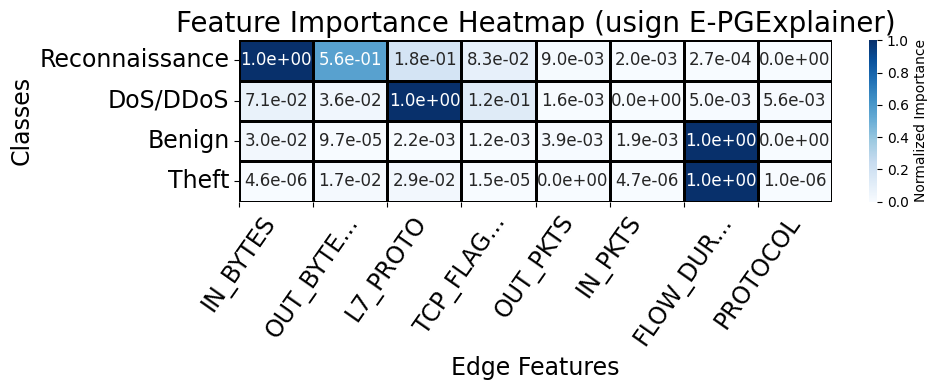

In [45]:
df = pd.DataFrame(final_scores).T.fillna(0)

# Normalize each row (optional, for better visual scaling)
# df_normalized = df.div(df.max(axis=1), axis=0)
df_normalized = (df - df.min(axis=1).values[:, None]) / (df.max(axis=1) - df.min(axis=1)).values[:, None]


max_label_len = 8  # You can adjust this
truncated_xticklabels = [
    f"{col[:max_label_len]}..." if len(col) > max_label_len else col
    for col in df.columns
]

# Plot heatmap
fsize = 17
plt.figure(figsize=(10, 4))
sns.heatmap(df_normalized, cmap='Blues', linewidths=1, linecolor='black', cbar_kws={'label': 'Normalized Importance'},annot=True,
    fmt=".1e", annot_kws={"size": 12}  )
plt.title("Feature Importance Heatmap (usign E-PGExplainer)",fontsize=20)
plt.xlabel("Edge Features",fontsize=fsize)
# plt.xticks(rotation=40,fontsize=14)
plt.xticks(
    ticks=range(len(truncated_xticklabels)),
    labels=truncated_xticklabels,
    rotation=55,
    fontsize=fsize
)
plt.ylabel("Classes",fontsize=fsize)
plt.yticks(rotation=0,fontsize=fsize)
plt.tight_layout()
plt.savefig('/scratch/kc01/na3038/TrainedModels/feature_matrix.png',bbox_inches='tight')
plt.show()


In [53]:
final_features ={key: [] for key in range(4)} 
final_scores = {k: {} for k in true_positives.keys()} #dict.fromkeys(true_positives.keys(), {})
for attack in true_positives.keys():  # ['Reconnaissance']true_positives.keys()[:1]: #['Theft']: #
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:50] # select 50 random edges from train data for each attack

    # train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 2.0,0.5
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        print(loss.item())
        optimizer_exp.step()
    # print(loss.item())

    #explain with trained model
    edges_to_explain = random.sample(true_positives[attack],50)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()
    print(edge_weight)
    feature_importance = {}
    for k in range(8):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      print(f'{key}: {value}') #display importance scores
      final_features[attack_id].append(cols_to_norm.index(key))
      final_scores[attack][key]=value

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
print(final_features)
print(final_scores)

---------- Reconnaissance ----------


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.15282747149467468
0.18010345101356506
0.2936819791793823
0.2819924056529999
0.2817506790161133
[3.47226523e-05 1.67419093e-05 9.63242928e-06 3.62332466e-05
 4.22380690e-05 1.12185626e-04 1.74318120e-06 4.28047024e-05]
IN_BYTES: 0.00011218562576686963
OUT_BYTES: 4.280470238882117e-05
OUT_PKTS: 4.22380689997226e-05
L7_PROTO: 3.623324664658867e-05
IN_PKTS: 3.472265234449878e-05
FLOW_DURATION_MILLISECONDS: 1.6741909348638728e-05
TCP_FLAGS: 9.632429282646626e-06
PROTOCOL: 1.7431812011636794e-06
---------- DoS/DDoS ----------


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.4532991051673889
0.5395473837852478
0.32867351174354553
0.28206780552864075
0.2817613184452057
[5.7628065e-05 2.2322488e-06 5.2282016e-06 2.2115712e-05 5.7068250e-06
 7.8758660e-07 1.2977315e-06 3.0041263e-06]
IN_PKTS: 5.762806540587917e-05
L7_PROTO: 2.2115711544756778e-05
OUT_PKTS: 5.706825049855979e-06
TCP_FLAGS: 5.228201644058572e-06
OUT_BYTES: 3.004126256200834e-06
FLOW_DURATION_MILLISECONDS: 2.232248789368896e-06
PROTOCOL: 1.2977315009266022e-06
IN_BYTES: 7.875866003814735e-07
---------- Benign ----------


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.3259604871273041
0.3283720016479492
0.311821848154068
0.28195419907569885
0.28174862265586853
[2.5113686e-05 2.2243032e-06 3.7587163e-06 1.2379202e-05 5.5520024e-07
 1.2385573e-04 1.3623378e-04 1.9607692e-06]
PROTOCOL: 0.00013623377890326083
IN_BYTES: 0.00012385573063511401
IN_PKTS: 2.5113686206168495e-05
L7_PROTO: 1.2379202416923363e-05
TCP_FLAGS: 3.758716275115148e-06
FLOW_DURATION_MILLISECONDS: 2.224303216280532e-06
OUT_BYTES: 1.9607691683631856e-06
OUT_PKTS: 5.5520024488942e-07
---------- Theft ----------


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.20606131851673126
0.2747868299484253
0.27706074714660645
0.2784896194934845
0.28171414136886597
[1.9777612e-05 7.8732082e-06 7.7363985e-08 1.0975896e-04 1.1301144e-06
 4.2836353e-05 5.8649385e-07 8.2060222e-07]
L7_PROTO: 0.0001097589629353024
IN_BYTES: 4.283635280444287e-05
IN_PKTS: 1.977761166926939e-05
FLOW_DURATION_MILLISECONDS: 7.87320823292248e-06
OUT_PKTS: 1.1301143558739568e-06
OUT_BYTES: 8.206022243939515e-07
PROTOCOL: 5.864938543709286e-07
TCP_FLAGS: 7.736398544011536e-08
{0: [6, 5, 0, 3, 2, 1, 7, 4], 1: [0, 3, 4, 2, 7, 1, 6, 5], 2: [5, 7, 4, 3, 0, 1, 2, 6], 3: [3, 5, 0, 1, 4, 7, 6, 2]}
{'Reconnaissance': {'IN_BYTES': 0.000112185626, 'OUT_BYTES': 4.2804702e-05, 'OUT_PKTS': 4.223807e-05, 'L7_PROTO': 3.6233247e-05, 'IN_PKTS': 3.4722652e-05, 'FLOW_DURATION_MILLISECONDS': 1.674191e-05, 'TCP_FLAGS': 9.632429e-06, 'PROTOCOL': 1.7431812e-06}, 'DoS/DDoS': {'IN_PKTS': 5.7628065e-05, 'L7_PROTO': 2.2115712e-05, 'OUT_PKTS': 5.706825e-06, 'TCP_FLAGS': 5.2282016e-06, 'OUT_BYTES': 3.004126

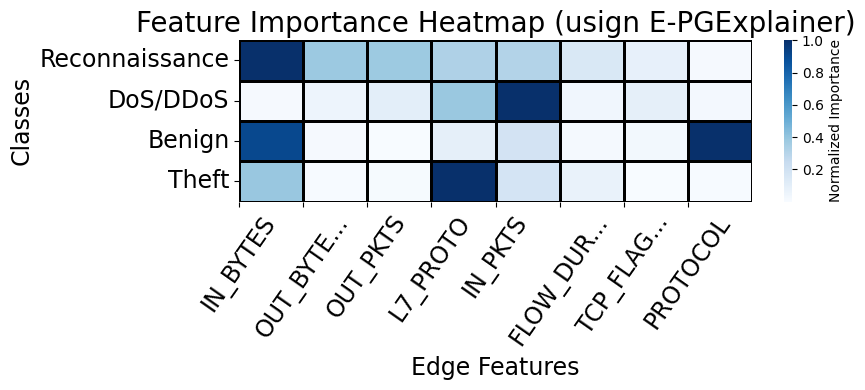

In [54]:
df = pd.DataFrame(final_scores).T.fillna(0)

# Normalize each row (optional, for better visual scaling)
df_normalized = df.div(df.max(axis=1), axis=0)

max_label_len = 8  # You can adjust this
truncated_xticklabels = [
    f"{col[:max_label_len]}..." if len(col) > max_label_len else col
    for col in df.columns
]

# Plot heatmap
fsize = 17
plt.figure(figsize=(9, 4))
sns.heatmap(df_normalized, cmap='Blues', linewidths=1, linecolor='black', cbar_kws={'label': 'Normalized Importance'})
plt.title("Feature Importance Heatmap (usign E-PGExplainer)",fontsize=20)
plt.xlabel("Edge Features",fontsize=fsize)
# plt.xticks(rotation=40,fontsize=14)
plt.xticks(
    ticks=range(len(truncated_xticklabels)),
    labels=truncated_xticklabels,
    rotation=55,
    fontsize=fsize
)
plt.ylabel("Classes",fontsize=fsize)
plt.yticks(rotation=0,fontsize=fsize)
plt.tight_layout()
plt.savefig('/scratch/kc01/na3038/TrainedModels/feature_matrix.png',bbox_inches='tight')
plt.show()


In [ ]:
# ---------- Reconnaissance ----------
# 0.6287718415260315
# OUT_PKTS: 3.688266474455304e-07
# OUT_BYTES: 2.0719909343824838e-07
# PROTOCOL: 1.604060315685274e-07
# IN_PKTS: 4.558545896315991e-08
# FLOW_DURATION_MILLISECONDS: 3.075654220197066e-08
# L7_PROTO: 5.963372462503003e-09
# IN_BYTES: 8.10827127661895e-10
# TCP_FLAGS: 2.2997063975349619e-10
# ========================================================
# ---------- DoS ----------
# 0.6290888786315918
# OUT_BYTES: 4.578065272653475e-06
# OUT_PKTS: 2.8130709779361496e-06
# PROTOCOL: 7.73023245415061e-08
# IN_BYTES: 1.924790815621691e-08
# FLOW_DURATION_MILLISECONDS: 1.671467764197132e-08
# TCP_FLAGS: 1.6463891583384793e-08
# IN_PKTS: 1.2060435317096108e-08
# L7_PROTO: 7.52913620338802e-10
# ========================================================
# ---------- Benign ----------
# 0.7331382632255554
# OUT_BYTES: 2.691496047191322e-05
# FLOW_DURATION_MILLISECONDS: 5.695277195627568e-06
# PROTOCOL: 5.539079211303033e-06
# TCP_FLAGS: 1.8539703887654468e-06
# IN_PKTS: 1.3461173011819483e-06
# L7_PROTO: 7.62279853461223e-07
# IN_BYTES: 6.231036309145566e-07
# OUT_PKTS: 5.872925967764786e-08
# ========================================================
# ---------- Theft ----------
# 0.6286560893058777
# L7_PROTO: 1.4261097476264695e-06
# OUT_PKTS: 4.6474275450236746e-07
# IN_BYTES: 1.6389110157888354e-07
# FLOW_DURATION_MILLISECONDS: 8.837299958486255e-08
# OUT_BYTES: 6.26822256322157e-08
# PROTOCOL: 2.0743904372011457e-08
# IN_PKTS: 1.981183750388027e-08
# TCP_FLAGS: 1.4837270301271133e-09
# ========================================================
# {0: [7, 4, 5, 6, 1, 3, 2, 0], 1: [7, 0, 5, 2, 4, 6, 1, 3], 2: [0, 7, 5, 1, 4, 3, 2, 6], 3: [3, 0, 2, 4, 7, 5, 1, 6]}

Codes for Single class Explain

### reconssiance attack - class-wise

In [152]:
final_features ={key: [] for key in range(4)}
for attack in ["Reconnaissance"]:
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:50] # select 50 random edges from train data for each attack

    ### train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 5.0, 1.0
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        optimizer_exp.step()
    print(loss.item())

    #explain with trained model
    edges_to_explain = random.sample(true_positives[attack],50)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()


    feature_importance = {}
    for k in range(8):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      print(f'{key}: {value}') #display importance scores
      final_features[attack_id].append(cols_to_norm.index(key))

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
print(final_features)

---------- Reconnaissance ----------


/jobfs/145202000.gadi-pbs/ipykernel_3959921/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.045305412262678146
IN_BYTES: 3.2694229700627456e-20
PROTOCOL: 1.1783297685742984e-20
IN_PKTS: 4.539038096904666e-21
L7_PROTO: 3.60438057551298e-23
TCP_FLAGS: 7.339044172207243e-25
FLOW_DURATION_MILLISECONDS: 1.4863596998145775e-26
OUT_BYTES: 2.1561144431867247e-28
OUT_PKTS: 1.0511229709504854e-28
{0: [], 1: [], 2: [4, 3, 0, 1, 2, 6, 5, 7], 3: []}


#### for single edge

In [66]:
for attack in ["Reconnaissance"]:
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:50] # select 50 random edges from train data for each attack

    ### train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 5.0, 1.0
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        optimizer_exp.step()
    print(loss.item())

    #explain with trained model
    edges_to_explain = 69467 #random.sample(true_positives[attack],1)
    print("edges_to_explain: ",edges_to_explain)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()


    feature_importance = {}
    for k in range(8):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      print(f'{key}: {value}') #display importance scores
      # final_features[attack_id].append(cols_to_norm.index(key))

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
# print(final_features)

---------- Reconnaissance ----------


/jobfs/145257347.gadi-pbs/ipykernel_3992057/1828839510.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0.2821693420410156
edges_to_explain:  69467
IN_PKTS: 0.00040641770465299487
L7_PROTO: 0.00012409110786393285
OUT_PKTS: 3.7659890949726105e-05
OUT_BYTES: 1.693681588221807e-05
TCP_FLAGS: 7.840823855076451e-06
FLOW_DURATION_MILLISECONDS: 9.688033060228918e-07
PROTOCOL: 2.6357574256508087e-07
IN_BYTES: 1.2619288725090883e-07


In [21]:
# 0.4215536415576935
# edges_to_explain:  0
# TCP_FLAGS: 0.03563801944255829
# IN_BYTES: 0.00905900914222002
# OUT_PKTS: 0.006902334280312061
# OUT_BYTES: 0.004943086300045252
# FLOW_DURATION_MILLISECONDS: 0.004238730296492577
# PROTOCOL: 0.002167114522308111
# IN_PKTS: 0.002084325300529599
# L7_PROTO: 0.0018014857778325677
# ========================================================

In [99]:
class ExplainerModel(nn.Module):
    def __init__(self):
        super(ExplainerModel, self).__init__()
        self.elayers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.elayers(x)
        # x = x.mean(dim=0)
        return x

In [100]:
#Updated Version
class PGExplainer(nn.Module):
    def __init__(self,model,num_hops=None,explain_graph=True,coff_budget=0.01, coff_connect=5e-4,sample_bias=0.0,):
      super(PGExplainer, self).__init__()
      self.elayers  = ExplainerModel()
      self.model = model
      self.graph_explanation = explain_graph
      self.num_hops = num_hops

      # training hyperparameters for PGExplainer
      self.coff_budget = coff_budget
      self.coff_connect = coff_connect
      self.sample_bias = sample_bias
      self.init_bias = 0.0

    def set_masks(self, graph, edge_mask=None):
        if edge_mask is None:
            num_nodes = graph.num_nodes()
            num_edges = graph.num_edges()

            init_bias = self.init_bias
            std = nn.init.calculate_gain("relu") * math.sqrt(
                2.0 / (2 * num_nodes)
            )
            self.edge_mask = torch.randn(num_edges) * std + init_bias
        else:
            self.edge_mask = edge_mask

        self.edge_mask = self.edge_mask.to(graph.device)

    def clear_masks(self):
        self.edge_mask = None
    def concrete_sample(self, w, beta=1.0, training=True):
          if training:
              bias = self.sample_bias
              random_noise = torch.rand(w.size()).to(w.device)
              random_noise = bias + (1 - 2 * bias) * random_noise
              gate_inputs = torch.log(random_noise) - torch.log(
                  1.0 - random_noise
              )
              gate_inputs = (gate_inputs + w) / beta
              gate_inputs = torch.sigmoid(gate_inputs)
          else:
              gate_inputs = torch.sigmoid(w)

          return gate_inputs

    def loss(self, prob, ori_pred):
        target_prob = prob.gather(-1, ori_pred.unsqueeze(-1))
        # 1e-6 added to prob to avoid taking the logarithm of zero
        target_prob += 1e-6
        # computing the log likelihood for a single prediction
        pred_loss = torch.mean(-torch.log(target_prob))

        # size
        edge_mask = self.sparse_mask_values
        if self.coff_budget <= 0:
            size_loss = self.coff_budget * torch.sum(edge_mask)
        else:
            size_loss = self.coff_budget * F.relu(
                torch.sum(edge_mask) - self.coff_budget
            )

        # entropy
        scale = 0.99
        edge_mask = self.edge_mask * (2 * scale - 1.0) + (1.0 - scale)
        mask_ent = -edge_mask * torch.log(edge_mask) - (
            1 - edge_mask
        ) * torch.log(1 - edge_mask)
        mask_ent_loss = self.coff_connect * torch.mean(mask_ent)

        loss = pred_loss + size_loss + mask_ent_loss
        return loss

    def train_step_node(self, edges, graph, temperature, **kwargs):
          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          prob, _, batched_graph, inverse_indices = self.explain_node(
              edges, graph, temperature, training=True, **kwargs
          )

          pred = self.model(
              batched_graph, self.batched_feats,self.batched_efeats, **kwargs
          )
          pred = pred.argmax(-1).data

          loss = self.loss(prob[inverse_indices], pred[inverse_indices])

          del batched_graph,_, inverse_indices,prob, pred

          torch.cuda.empty_cache()

          return loss

    def explain_node(self, edges, graph, temperature=1.0, training=False, **kwargs):
          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if training:
              self.elayers.train()
          else:
              self.elayers.eval()

          self.model.eval()

          batched_graph = []
          batched_embed = []
          for edge_id in edges:
              sg, inverse_indices =  generate_computation_graph(graph, edge_id)
              sg.ndata["feat"]= features[sg.ndata[NID].long()]
              sg.edata["feat"]= edge_features[sg.edata[EID].long()]
              # feats = features[sg.ndata[NID].long()]
              # efeats = edge_features[sg.edata[EID].long()]
              sg.edata["train"] = torch.tensor(
                [eid in inverse_indices for eid in sg.edges(form='eid')], device=sg.device
              )
              embed = self.model(sg, sg.ndata["feat"],sg.edata["feat"],embed=True)
              embed = embed.data

              # col, row = sg.edges()
              # col_emb = embed[col.long()]
              # row_emb = embed[row.long()]
              # self_emb = embed[inverse_indices[0]].repeat(sg.num_edges(), 1)
              # need to concat these if considering combine node-based edge embeddings with raw edge features
              emb = create_explainer_input(sg.edges(), embed) # i think not needed because we do not consider on node embeddings
              batched_embed.append(emb)
              batched_graph.append(sg)
              # print("train step edge:",edge_id)

          batched_graph = batch(batched_graph)

          batched_embed = torch.cat(batched_embed)
          batched_embed = self.elayers(batched_embed) #1,1
          values = batched_embed.reshape(-1) # 1
          values = self.concrete_sample(
              values, beta=temperature, training=training
          )
          self.sparse_mask_values = values

          # col, row = batched_graph.edges()
          # reverse_eids = batched_graph.edge_ids(row, col).long()
          # edge_mask = (values + values[reverse_eids]) / 2
          # todo
          edge_mask = values

          self.set_masks(batched_graph, edge_mask)

          batched_feats = batched_graph.ndata['feat']
          batched_efeats = batched_graph.edata['h']
          # the model prediction with the updated edge mask
          logits = self.model(
              batched_graph, batched_feats, batched_efeats, edge_weight=self.edge_mask, **kwargs
          )
          probs = F.softmax(logits, dim=-1)
          # print(probs.shape)

          # batched_inverse_indices = (
          #     batched_graph.edata["train"].nonzero().squeeze(1)
          # )

          if training:
              self.batched_feats = batched_feats
              self.batched_efeats = batched_efeats
              probs = probs.data
          else:
              self.clear_masks()

          if training:
            batched_inverse_indices = (
                batched_graph.edata["train"].nonzero().squeeze(1)
            )
          else:
            for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
              if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                      edge_indice = indx
                      break
            batched_inverse_indices= edge_indice
            batched_graph = sg

          del batched_feats, batched_efeats, logits
          torch.cuda.empty_cache()
          return (
              probs,
              edge_mask,
              batched_graph,
              batched_inverse_indices,
          )

In [93]:
features = G_test.ndata['feature']
edge_features = G_test.edata['h']
labels = G_test.edata['label']
explainer = PGExplainer(
            model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
        )
explainer = explainer.to('cuda')

In [101]:
def explain_edges(explainer):
    for attack in ["Reconnaissance"]:
        print ("----------", attack,"----------")
        attack_id = le.transform([attack])[0]
        class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
        selected_indices = class_indices[torch.randperm(class_indices.size(0))][:5] # select 50 random edges from train data for each attack        
    
        torch.cuda.empty_cache()
        init_tmp, final_tmp = 5.0, 0.5
        optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
        epochs = 3
        train_losses = []
        for epoch in range(epochs):
            # tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
            tmp = init_tmp * ((final_tmp / init_tmp) ** (epoch / epochs))
            loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
            train_losses.append(loss.item())
            optimizer_exp.zero_grad()
            loss.backward()
            optimizer_exp.step()
            print(loss.item())
        # epochs = range(0, 5)
        # plt.figure(figsize=(6, 4))
        # plt.plot(epochs, train_losses, label='Train Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.title('Train Loss Over Epochs')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
    
        #explain with trained model
        # edges_to_explain =7834  #random.sample(true_positives[attack],1)
        edges_to_explain = int(list((G_test.edata['Edge_indx'] == 56708 ).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0])#7834
        print("edges_to_explain: ",edges_to_explain)
        probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
        del explainer, train_losses
        torch.cuda.empty_cache()
        print('========================================================')
    # print(final_features)
    return probs, edge_weight, bg, inverse_indices

In [102]:
probs, edge_weight, bg, inverse_indices = explain_edges(explainer)

---------- Reconnaissance ----------


DGLError: Expect number of features to match number of edges. Got 25466 and 141598 instead.

In [81]:
bg

Graph(num_nodes=14, num_edges=26,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1, 8), dtype=torch.float32), 'train': Scheme(shape=(), dtype=torch.bool)})

In [82]:
edge_weight

tensor([1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07,
        1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07,
        1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07,
        1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07, 1.7476e-07,
        1.7476e-07, 1.7476e-07], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [86]:
edge_weight_mul=edge_weight*10000000
edge_weight_mul

tensor([1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476,
        1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476,
        1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476, 1.7476],
       device='cuda:0', grad_fn=<MulBackward0>)

In [208]:
edge_mask_intrusion_round = th.round(attck_edge_mask)
unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
# unwanted_1 = list((edge_weight_mul < 0.55).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if inverse_indices in unwanted_1:
    unwanted_1.remove(inverse_indices)

print(len(unwanted_1))

36


In [209]:
import dgl
g_intrusion = dgl.remove_edges(bg, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)

nx_graph_intrusion_Label = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss = list(nx_graph_intrusion_Label.keys())
valuess = list(nx_graph_intrusion_Label.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], int(x[1])])] = valuess[indx].item() #le.inverse_transform([valuess[indx]]).item() #valuess[indx].item()

nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == bg.edata["Edge_indx"][inverse_indices].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])

{(0, 5): Text(0.7342042032659765, 0.44175604026131116, '167447'),
 (1, 9): Text(0.3032412240813963, 0.5719735773612058, '162613'),
 (2, 11): Text(0.09078997502056046, 0.5537942948408505, '61162'),
 (2, 15): Text(-0.043281255678358055, 0.1558850192156928, '172938'),
 (3, 8): Text(0.31715557075668105, 0.7960003613454509, '2373'),
 (3, 13): Text(-0.07578003254512516, 0.46223785020608626, '27700'),
 (3, 21): Text(0.3171556005590034, -0.19082617629973436, '34273'),
 (3, 20): Text(0.21297755948649996, -0.1619012939286496, '36815'),
 (3, 12): Text(-0.030382005904486198, 0.5603640677903226, '43496'),
 (3, 19): Text(0.11745295053258248, -0.1112573432994517, '68362'),
 (3, 18): Text(0.035048784188985715, -0.0412625957596548, '73120'),
 (3, 28): Text(0.8863568009551839, 0.19510178343153722, '80986'),
 (3, 24): Text(0.632250667137992, -0.13916897651310894, '85968'),
 (3, 6): Text(0.5318107611596175, 0.784362077632343, '106747'),
 (3, 14): Text(-0.09902241670761047, 0.3566466500631805, '118824'),
 

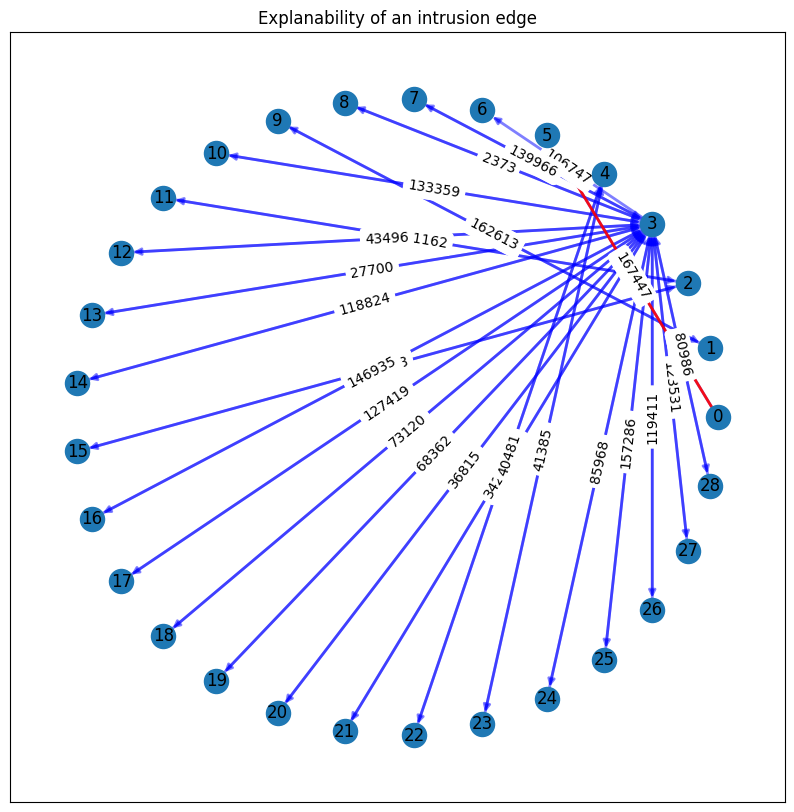

In [78]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[10,10])
plt.title("Explanability of an intrusion edge")
pos = nx.circular_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

{(0, 28): Text(0.9883102476762013, -0.10748530806365475, '15139'),
 (1, 28): Text(0.9766205251547249, -8.837930075278333e-08, '157704'),
 (2, 28): Text(0.9420979619844363, 0.10245923786237171, '13325'),
 (3, 28): Text(0.8863568009551839, 0.19510178343153722, '23758'),
 (4, 28): Text(0.8120034041677007, 0.27359570626945934, '43166'),
 (5, 28): Text(0.7225144509421778, 0.3342707311699901, '101729'),
 (6, 28): Text(0.6220744555568362, 0.37428967704583, '120302'),
 (9, 28): Text(0.303241194279074, 0.3570030485855308, '103092'),
 (11, 28): Text(0.12531250838852676, 0.23636443982350297, '152582'),
 (12, 28): Text(0.05988168849273251, 0.1502916672038096, '72530'),
 (13, 28): Text(0.014483661852093543, 0.052165449619573256, '47852'),
 (16, 28): Text(0.014483661852093543, -0.26713603594456037, '132543'),
 (18, 28): Text(0.12531247858620442, -0.4513349963461678, '106568'),
 (19, 28): Text(0.2077166449298012, -0.5213297438859648, '53191'),
 (20, 28): Text(0.3032412538837187, -0.5719736945151626, 

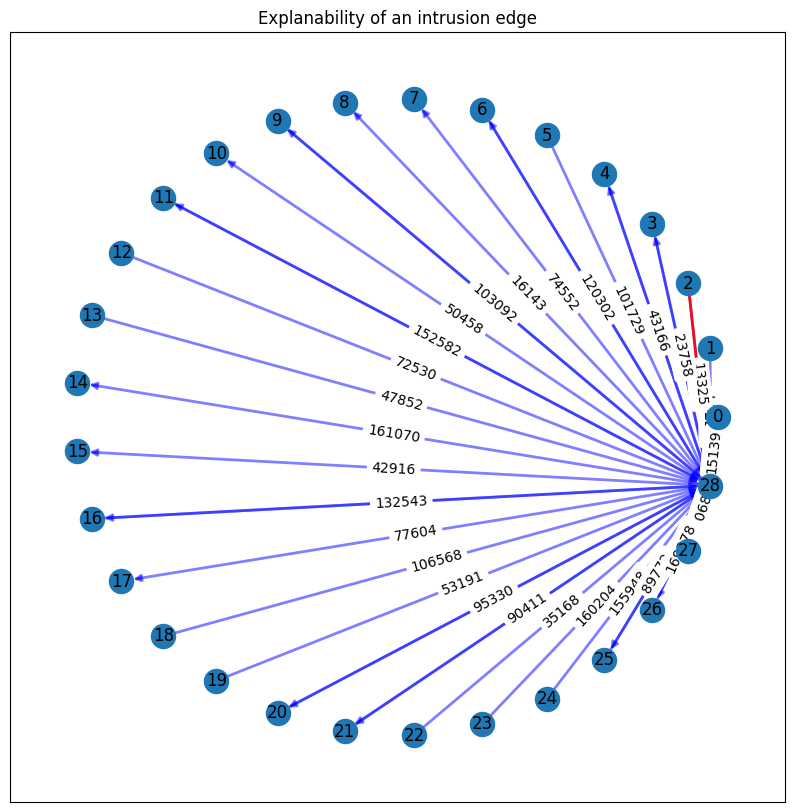

In [210]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[10,10])
plt.title("Explanability of an intrusion edge")
pos = nx.circular_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

# E-GNNExplainer

In [51]:
from math import sqrt
from tqdm import tqdm
from dgl import EID,NID,khop_out_subgraph, khop_in_subgraph
import dgl
from sklearn.utils import class_weight
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from scipy.stats import linregress

linear_threshold = 0.001  # Threshold for the slope to be considered "linear"
lookback_epochs = 200  # Number of epochs to check for linearity

def init_efeat_masks(graph, efeat):
    efeat_size = efeat.size()[2]
    num_edges = graph.num_edges()
    num_nodes = graph.num_nodes()
    device = efeat.device
    std = 0.1
    # feat_mask = [[f1, f2, .... fn]] / n = nb_features
    efeat_mask = nn.Parameter(th.randn(1, efeat_size, device=device) * std)
    std = nn.init.calculate_gain("relu") * sqrt(2.0 / (2 * num_edges))
    return efeat_mask


# Regularization loss
def loss_regularize_efeat(loss, feat_mask):
    eps = 1e-15
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    feat_mask = feat_mask.sigmoid()
    loss = loss + beta1 * th.mean(feat_mask)
    ent = -feat_mask * th.log(feat_mask + eps) - (
        1 - feat_mask
    ) * th.log(1 - feat_mask + eps)
    loss = loss + beta2 * ent.mean()
    return loss



# Edge mask
def explain_edge_features(model, edge_id, graph, node_feat, edge_feat, **kwargs):
    model = model.to(graph.device)
    model.eval()

    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)

    sg = dgl.add_edges(sg, inverse_indices.item(), dest_node)
    # So we can add its features in last position
    sg.edata['Edge_indx'][-1] = graph.edata['Edge_indx'][edge_id]
    sg.edata['label'][-1] = graph.edata['label'][edge_id]
    sg.edata['h'][-1][0] = graph.edata['h'][edge_id]

    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break

    # EID = NID = _ID
    # tensor([0, 1, 2, 4]) : nodes and edges ids
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]

    edge_label_1 = sg.edata["label"][edge_indice]

    # edge_mask
    efeat_mask = init_efeat_masks(sg, edge_feat)
    params = [efeat_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=1, epochs=250)

    criterion2 = nn.CrossEntropyLoss()
    # criterion2 = nn.BCEWithLogitsLoss()
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)
    import datetime

    xai_train_losses = []
    scaler = GradScaler()
    for epoch in range(1, 250):
        optimizer.zero_grad()
        # Apply edge feature mask
        h = edge_feat * efeat_mask.sigmoid()
        # Edge mask
        logits = model(g = sg, nfeats = node_feat, efeats = h,**kwargs).cuda()
        # predicted_classes= logits[:, edge_label_1, :].squeeze()
        # predicted_classes = th.argmax(logits, dim=1).squeeze()
        loss = criterion2(logits[edge_indice], edge_label_1)
        # loss = loss_regularize(loss11, edge_mask)
        xai_train_losses.append(loss.item())
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if epoch >= lookback_epochs:
          # Calculate the slope of the recent `lookback_epochs` losses
          recent_losses = xai_train_losses[-lookback_epochs:]
          epochs_range = np.arange(lookback_epochs)
          slope, _, _, _, _ = linregress(epochs_range, recent_losses)

          # Check if the slope is below the threshold for linearity
          if abs(slope) < linear_threshold:
              # print(f"Stopping early at epoch {epoch} due to linear loss with slope {slope:.5f}")
              break

        del logits #, predicted_classes
        th.cuda.empty_cache()


    # epochs = range(0, len(xai_train_losses))
    # plt.figure(figsize=(6, 4))
    # # xai_train_losses =  [tensor.cpu().detach().numpy() for tensor in xai_train_losses]
    # plt.plot(epochs, xai_train_losses, label='Train Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.show()
    # efeat_mask = efeat_mask.detach().sigmoid().squeeze()
    del xai_train_losses, epochs_range, slope
    th.cuda.empty_cache()
    return edge_indice, sg, efeat_mask, loss.item()

In [52]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
labels = G_test.edata['label']
final_feature_weights ={key: [] for key in range(4)}

In [53]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
final_features ={key: [] for key in range(4)}
final_scores = {k: {} for k in true_positives.keys()}

for i in range(0,4):
  attk_class = le.inverse_transform([i])[0]
  print('Class type explaining:', attk_class)
  attack_edge_to_explain = 0 #initialize
  attack_feature_array = {}
  true_predicted_edge_indexes = random.sample(true_positives[attk_class], 50) #50
  for edge_index in true_predicted_edge_indexes:
      attack_indices_list = (G_test.edata['Edge_indx'] == edge_index).nonzero(as_tuple=True)[0].to("cuda").tolist()
      if len(true_predicted_edge_indexes)>0:
        attack_edge_to_explain = attack_indices_list[0]
        attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats)
        attack_feature_array[edge_index] = (attck_efeat_mask.cpu().detach().tolist())
  lists = list(attack_feature_array.values())
  flat_lists = [item[0] for item in lists]
  averages = [sum(values) / len(values) for values in zip(*flat_lists)]

  feature_importance = {}
  for k in range(8):
    feature_importance[cols_to_norm[k]]=averages[k]

  sorted_items_gnn = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
  for key, value in sorted_items_gnn:
    print(f'{key}: {value}') #display importance scores
    final_features[i].append(cols_to_norm.index(key))
    final_scores[attk_class][key]=value

  del true_predicted_edge_indexes, attack_feature_array, lists, averages, feature_importance
  torch.cuda.empty_cache()
  print('========================================================')
# print(sorted_items_gnn)
print(final_features)
print(final_scores)

Class type explaining: Benign
PROTOCOL: 0.3082787725329399
FLOW_DURATION_MILLISECONDS: 0.2081693059206009
TCP_FLAGS: 0.14522996351122855
IN_BYTES: 0.14271978955715894
L7_PROTO: 0.03965353025123477
IN_PKTS: -0.00544662207365036
OUT_BYTES: -0.25843647312372925
OUT_PKTS: -0.36745875254273414
Class type explaining: DoS/DDoS
TCP_FLAGS: 0.74431097894907
L7_PROTO: 0.614730534851551
OUT_PKTS: 0.4231175065040588
PROTOCOL: 0.32460153159685434
IN_PKTS: 0.0028416949510574343
IN_BYTES: -0.27679274588823316
OUT_BYTES: -0.27943098708987235
FLOW_DURATION_MILLISECONDS: -0.5393183552473784
Class type explaining: Reconnaissance
OUT_PKTS: 0.8826003098487853
OUT_BYTES: 0.8650244012475014
PROTOCOL: 0.859893662929535
FLOW_DURATION_MILLISECONDS: 0.7884537863731385
L7_PROTO: 0.7760273730754852
TCP_FLAGS: 0.7726240372657776
IN_PKTS: 0.5056699866056442
IN_BYTES: -0.6510597760789096
Class type explaining: Theft
PROTOCOL: 0.6937795634932664
L7_PROTO: 0.6852371119704022
OUT_PKTS: -0.03808593917257932
FLOW_DURATION_

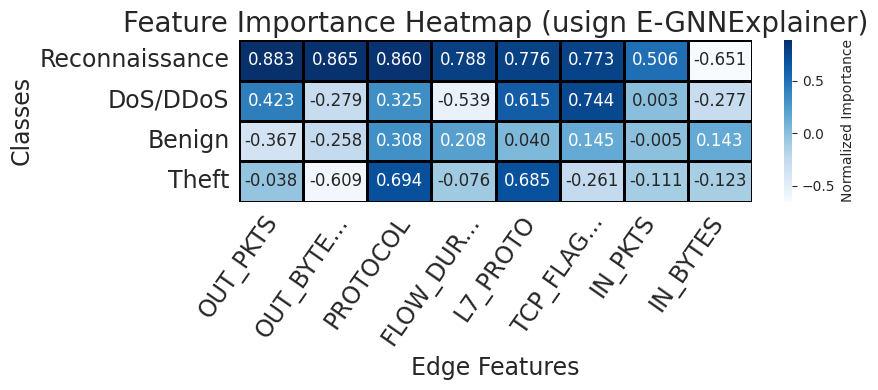

In [58]:
# {0: [2, 1, 6, 7, 3, 4, 0, 5], 1: [2, 1, 5, 3, 0, 7, 6, 4], 2: [2, 1, 3, 7, 0, 5, 4, 6], 3: [7, 6, 3, 5, 1, 2, 4, 0]}
# {'DoS/DDoS': {'TCP_FLAGS': 0.8975546634197236, 'L7_PROTO': 0.8835694658756256, 'OUT_BYTES': 0.5139534971117974, 'PROTOCOL': 0.31715757488273083, 'IN_PKTS': 0.23554920077323913, 'OUT_PKTS': 0.16769402146339416, 'FLOW_DURATION_MILLISECONDS': 0.046466488018631937, 'IN_BYTES': -0.022618268728256227}, 'Benign': {'TCP_FLAGS': -0.02801121948286891, 'L7_PROTO': -0.0473504076898098, 'FLOW_DURATION_MILLISECONDS': -0.14906279135495423, 'OUT_PKTS': -0.22877410802990197, 'PROTOCOL': -0.26019165486097334, 'IN_BYTES': -0.32538067776709795, 'IN_PKTS': -0.37382982173003254, 'OUT_BYTES': -0.5528244543448091}, 'Reconnaissance': {'TCP_FLAGS': 0.8990487424284219, 'L7_PROTO': 0.7877910590171814, 'PROTOCOL': 0.7072291612625122, 'OUT_PKTS': 0.6964318579435349, 'IN_PKTS': 0.6775839048624038, 'OUT_BYTES': 0.6750252813100814, 'IN_BYTES': 0.6342383223772049, 'FLOW_DURATION_MILLISECONDS': -0.20021750926971435}, 'Theft': {'OUT_PKTS': 0.6011289373661081, 'FLOW_DURATION_MILLISECONDS': 0.43346678184267756, 'PROTOCOL': 0.41668321502705413, 'OUT_BYTES': -0.18777805690964064, 'L7_PROTO': -0.40773496000717085, 'TCP_FLAGS': -0.43222253924856585, 'IN_BYTES': -0.6955304265235706, 'IN_PKTS': -0.7260642011339465}}

df = pd.DataFrame(final_scores).T.fillna(0)

# Normalize each row (optional, for better visual scaling)
df_normalized = df
    # .div(df.max(axis=1), axis=0)

max_label_len = 8  # You can adjust this
truncated_xticklabels = [
    f"{col[:max_label_len]}..." if len(col) > max_label_len else col
    for col in df.columns
]

# Plot heatmap
fsize = 17
plt.figure(figsize=(9, 4))
sns.heatmap(df_normalized, cmap='Blues', linewidths=1, linecolor='black', cbar_kws={'label': 'Normalized Importance'},annot=True,
    fmt=".3f", annot_kws={"size": 12})
plt.title("Feature Importance Heatmap (usign E-GNNExplainer)",fontsize=20)
plt.xlabel("Edge Features",fontsize=fsize)
# plt.xticks(rotation=40,fontsize=14)
plt.xticks(
    ticks=range(len(truncated_xticklabels)),
    labels=truncated_xticklabels,
    rotation=55,
    fontsize=fsize
)
plt.ylabel("Classes",fontsize=fsize)
plt.yticks(rotation=0,fontsize=fsize)
plt.tight_layout()
plt.savefig('/scratch/kc01/na3038/TrainedModels/feature_matrix_gnn.png',bbox_inches='tight')
plt.show()


In [ ]:
# Class type explaining: Benign
# IN_BYTES: 0.5096440176106989
# TCP_FLAGS: 0.5016285622119904
# FLOW_DURATION_MILLISECONDS: 0.2696079763397574
# IN_PKTS: 0.1523496152460575
# PROTOCOL: 0.05049285896122455
# OUT_BYTES: -0.2121703615784645
# OUT_PKTS: -0.2651218831539154
# L7_PROTO: -0.30746547162532806
# ========================================================
# Class type explaining: DoS
# L7_PROTO: 0.8529531425982714
# PROTOCOL: 0.8062105301953852
# IN_PKTS: 0.6438065309822559
# TCP_FLAGS: 0.5713944116234779
# OUT_BYTES: 0.43280345857143404
# OUT_PKTS: 0.3951264733076096
# FLOW_DURATION_MILLISECONDS: -0.22099237650632858
# IN_BYTES: -0.42630209743976594
# ========================================================
# Class type explaining: Reconnaissance
# IN_PKTS: 0.8409380620718002
# PROTOCOL: 0.8379999566078186
# TCP_FLAGS: 0.8236770820617676
# OUT_PKTS: 0.8078510749340058
# OUT_BYTES: 0.6744910234212875
# FLOW_DURATION_MILLISECONDS: 0.5647123933723196
# IN_BYTES: 0.5055884365551173
# L7_PROTO: 0.3021579933486646
# ========================================================
# Class type explaining: Theft
# PROTOCOL: 0.7256568740217053
# L7_PROTO: 0.6177534102177134
# OUT_PKTS: 0.11812404953703588
# FLOW_DURATION_MILLISECONDS: 0.00446160373334982
# TCP_FLAGS: -0.03542961434898328
# IN_PKTS: -0.11561037434683162
# IN_BYTES: -0.254718579351902
# OUT_BYTES: -0.4326243210507899
# ========================================================
# {0: [2, 6, 4, 1, 5, 7, 0, 3], 1: [3, 5, 1, 6, 7, 0, 4, 2], 2: [1, 5, 6, 0, 7, 4, 2, 3], 3: [5, 3, 0, 4, 6, 1, 2, 7]}


In [59]:
attack_indices_list = (G_test.edata['Edge_indx'] == 69467).nonzero(as_tuple=True)[0].to("cuda").tolist()
# if len(true_predicted_edge_indexes)>0:
attack_edge_to_explain = attack_indices_list[0]
attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats)
lists = attck_efeat_mask.cpu().detach().tolist()[0]
print(attck_efeat_mask)

feature_importance = {}
for k in range(8):
  feature_importance[cols_to_norm[k]]=lists[k]

sorted_items_gnn = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
for key, value in sorted_items_gnn:
  print(f'{key}: {value}') #display importance scores
# Parameter containing:
# tensor([[ 0.9228,  1.0873,  1.6522, -0.6901,  0.2064,  0.8037,  0.6912,  0.7943]],
#        device='cuda:0', requires_grad=True)
# IN_BYTES: 1.6521923542022705
# IN_PKTS: 1.0873312950134277
# OUT_PKTS: 0.9228017330169678
# PROTOCOL: 0.8036712408065796
# OUT_BYTES: 0.7943319082260132
# TCP_FLAGS: 0.691209614276886
# FLOW_DURATION_MILLISECONDS: 0.20643319189548492
# L7_PROTO: -0.6900508999824524

Parameter containing:
tensor([[ 0.9869,  0.6989,  0.7794,  0.7475,  0.8533, -0.3226,  0.7757,  1.2022]],
       device='cuda:0', requires_grad=True)
OUT_BYTES: 1.2022465467453003
IN_PKTS: 0.9869135618209839
OUT_PKTS: 0.853299081325531
TCP_FLAGS: 0.7794052362442017
PROTOCOL: 0.7757488489151001
L7_PROTO: 0.747530460357666
FLOW_DURATION_MILLISECONDS: 0.6988965272903442
IN_BYTES: -0.32262948155403137


#### Mutual Info

In [45]:
all_tps = [v for values in true_positives.values() for v in values[:1000]]
len(all_tps)

3896

In [163]:
indx_to_explain = []

edges_to_explain= true_positives['Reconnaissance'][:10000]
for x in edges_to_explain:
    indx_to_explain.append((G_test.edata['Edge_indx'] == x).nonzero(as_tuple=True)[0][0].item())

df_indx = pd.DataFrame(columns = ['Edge_indx', 'label'])

for x in indx_to_explain:
    df_indx.loc[-1] = [x, G_test.edata['label'][x].item()]  # adding a row
    df_indx.index = df_indx.index + 1  # shifting index

    
df_indx = df_indx.sort_values('label')
print(df_indx)

# print('nb attacks :', len(df_indx.loc[df_indx['label'] == 1]))
# print('nb benign :', len(df_indx.loc[df_indx['label'] == 0]))
df2_indx = pd.DataFrame(columns = ['Edge_indx', 'label', 'in_out_degrees'])

      Edge_indx  label
9999          0      2
3336      49893      2
3335      49894      2
3334      49895      2
3333      49896      2
...         ...    ...
6665      17773      2
6664      17774      2
6663      17775      2
6670      17768      2
0         53732      2

[10000 rows x 2 columns]


In [363]:
min_count=20000
e=0
for x in df_indx['label'].unique():
    # select the edges having a neighborhood subgraph with 100 <= nb_edges =< 200
    list1 = df_indx.loc[df_indx['label'] == x]['Edge_indx']
    for y in list1:
      source_node = th.Tensor.cpu(G_test.edges()[0][int(y)]).detach().numpy()
      
#       sg, inverse_indices = khop_out_subgraph(G_test, source_node, 2)
#       edge_count = sg.num_edges()
#       if edge_count<min_count:
#           min_count=edge_count
#           e=y
# print(min_count,e)
      if (20 <= edge_count <= 1000) :
        print (edge_count, y)
        df2_indx.loc[-1] = [int(y), x, edge_count]  # adding a row
        df2_indx.index = df2_indx.index + 1  # shifting index
          
      # in_out_degrees = G_test.in_degrees(source_node) + G_test.out_degrees(source_node)
      # # print(in_out_degrees)
      # if (10 >= in_out_degrees.item() <= 100) :
      #   df2_indx.loc[-1] = [int(y), x, in_out_degrees.item()]  # adding a row
      #   df2_indx.index = df2_indx.index + 1  # shifting index

# print(df2_indx)
results_dff = df2_indx.apply(pd.to_numeric)
# min_rows = results_dff[results_dff['in_out_degrees'] == results_dff['in_out_degrees'].min()]
min_rows = results_dff[
    (results_dff['label'] == 2) &
    (results_dff['in_out_degrees'] == results_dff[results_dff['label'] == 2]['in_out_degrees'].min())
]
print(min_rows.head())

      Edge_indx  label  in_out_degrees
4435      53131      2               4
4434      53131      2               4
3990      50814      2               4
1308      14696      2               4
1307      14696      2               4


### Explain edge importance

In [73]:
#init mask
def init_masks(graph, efeat):
  efeat_size= efeat.size()[1]
  num_edges = graph.num_edges()
  num_nodes = graph.num_nodes()
  device = efeat.device
  std=0.1
  std= nn.init.calculate_gain("relu") * sqrt (2.0/ (2 * num_nodes))
  edge_mask = nn.Parameter(th.randn(num_edges, device=device)*std)
  return edge_mask

# Regularization loss
def loss_regularize(loss, edge_mask):
    eps = 1e-15
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    edge_mask = edge_mask.sigmoid()
    loss = loss + th.from_numpy(alpha1 * th.Tensor.cpu(th.sum(edge_mask)).detach().numpy()).cuda()
    ent = -edge_mask * th.log(edge_mask + eps) - (
        1 - edge_mask
    ) * th.log(1 - edge_mask + eps)
    loss = loss + alpha2 * ent.mean()
    return loss


linear_threshold = 0.001  # Threshold for the slope to be considered "linear"
lookback_epochs = 200  # Number of epochs to check for linearity
# Edge mask
def explain_edges(model, edge_id, graph, node_feat, edge_feat,class_idx=None, **kwargs):
    model = model.to(graph.device)
    model.eval()

    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_out_subgraph(graph, source_node, num_hops)
    print(sg)

    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]

    edge_label_1 = sg.edata["label"][edge_indice]
    if class_idx !=None:
      edge_label_1 = (edge_label_1 == class_idx)
    # print(edge_label_1)

    # edge_mask
    edge_mask = init_masks(sg, edge_feat)
    params = [edge_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=1, epochs=250)

    # criterion2 = nn.BCEWithLogitsLoss()
    criterion2 = nn.CrossEntropyLoss()
    # criterion2 = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device='cuda'))
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)

    xai_train_losses = []
    scaler = GradScaler()
    for epoch in range(1, 250):#250
        # optimizer.zero_grad()
        # Edge mask
        # logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, edge_weight=edge_mask.sigmoid(),class_idx=class_idx).cuda() #edge_mask.sigmoid()
        logits = model(g = sg, nfeats = node_feat, efeats = edge_feat,edge_weight=edge_mask.sigmoid(),**kwargs).cuda()
        # predicted_classes= logits[:, edge_label_1, :].squeeze()
        # predicted_classes = th.sigmoid(logits)
        # print(predicted_classes[edge_indice],edge_label_1.float().view(-1))
        # loss11 = criterion2(predicted_classes[edge_indice], edge_label_1.float().view(-1))
        loss11 = criterion2(logits[edge_indice], edge_label_1)
        loss = loss_regularize(loss11, edge_mask)
        xai_train_losses.append(loss.item())
        # print(loss.item())
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if epoch >= lookback_epochs:
          # Calculate the slope of the recent `lookback_epochs` losses
          recent_losses = xai_train_losses[-lookback_epochs:]
          epochs_range = np.arange(lookback_epochs)
          slope, _, _, _, _ = linregress(epochs_range, recent_losses)

          # Check if the slope is below the threshold for linearity
          if abs(slope) < linear_threshold:
              print(f"Stopping early at epoch {epoch} due to linear loss with slope {slope:.5f}")
              break

        del logits
        th.cuda.empty_cache()

    epochs = range(0, len(xai_train_losses))
    plt.figure(figsize=(6, 4))
    # xai_train_losses =  [tensor.cpu().detach().numpy() for tensor in xai_train_losses]
    plt.plot(epochs, xai_train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    edge_mask = edge_mask.detach().sigmoid()
    th.cuda.empty_cache()
    return edge_indice, sg, edge_mask, loss.item()

243895
Graph(num_nodes=27, num_edges=52,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})


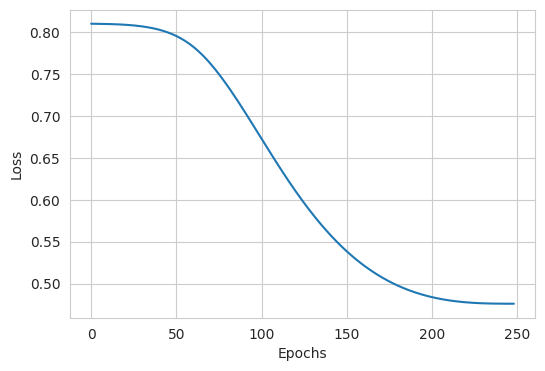

tensor([0.8822, 0.1216, 0.1213, 0.8800, 0.1211, 0.1178, 0.8788, 0.8843, 0.1216,
        0.8796, 0.1211, 0.8850, 0.1200, 0.1002, 0.1148, 0.1208, 0.8806, 0.8833,
        0.1214, 0.1212, 0.1186, 0.1201, 0.1153, 0.1215, 0.1214, 0.8848, 0.1159,
        0.8849, 0.1187, 0.8820, 0.8784, 0.1158, 0.8850, 0.8832, 0.1211, 0.1172,
        0.8831, 0.1189, 0.8804, 0.1173, 0.8803, 0.1184, 0.8793, 0.1194, 0.1153,
        0.1159, 0.1213, 0.8859, 0.8854, 0.1170, 0.8786, 0.1132],
       device='cuda:0')


In [103]:
# 69467
attack_edge_to_explain = list((G_test.edata['Edge_indx'] ==69467 ).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]
print(attack_edge_to_explain)
attck_edge_indice, attck_sub_graph, attck_edge_mask, attck_loss = explain_edges(model, attack_edge_to_explain, G_test, nfeats, efeats)#,class_idx=1
print(attck_edge_mask)

In [75]:
# len(list((attck_edge_mask < 0.553).nonzero(as_tuple=True)[0].cpu().detach().numpy()))
attck_edge_mask

tensor([0.1216, 0.1187, 0.8869, 0.1157, 0.1200, 0.8784, 0.1144, 0.8788, 0.8815,
        0.1146, 0.8839, 0.1148, 0.1193, 0.8831, 0.1161, 0.8798, 0.1190, 0.1132,
        0.8793, 0.1182, 0.8861, 0.1211, 0.1209, 0.1137, 0.1169, 0.8785, 0.8810,
        0.8790, 0.1165, 0.1165, 0.8869, 0.8785, 0.8784, 0.1214, 0.1128, 0.1146,
        0.8793, 0.8863, 0.8786, 0.1152, 0.1210, 0.1158, 0.8794, 0.1171, 0.1215,
        0.8867, 0.8785, 0.8789, 0.1202, 0.8786, 0.8866, 0.1149],
       device='cuda:0')

In [77]:
print(attck_sub_graph)
edge_mask_intrusion_round = th.round(attck_edge_mask)
unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
# unwanted_1 = list((attck_edge_mask < 0.001).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if attck_edge_indice in unwanted_1:
    unwanted_1.remove(attck_edge_indice)

print(len(unwanted_1))

Graph(num_nodes=27, num_edges=52,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})
28


In [78]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

In [79]:
g_intrusion

Graph(num_nodes=18, num_edges=24,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [80]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)

nx_graph_intrusion_Label = nx.get_edge_attributes(nx_graph_intrusion, "label")
keyss = list(nx_graph_intrusion_Label.keys())
valuess = list(nx_graph_intrusion_Label.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = 'Recon' #le.inverse_transform([valuess[indx]]).item() #valuess[indx].item()


nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == attck_sub_graph.edata["Edge_indx"][attck_edge_indice].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])

# u=orange_edge[0]
# v=orange_edge[1]
# for component in nx.weakly_connected_components(nx_graph_intrusion):
#         if u in component and v in component:
#             nodes_to_keep = component
#             break

# G_nx_sub = G_nx_simple.subgraph(nodes_to_keep).copy()


/jobfs/145156197.gadi-pbs/ipykernel_336075/821889718.py:11: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout


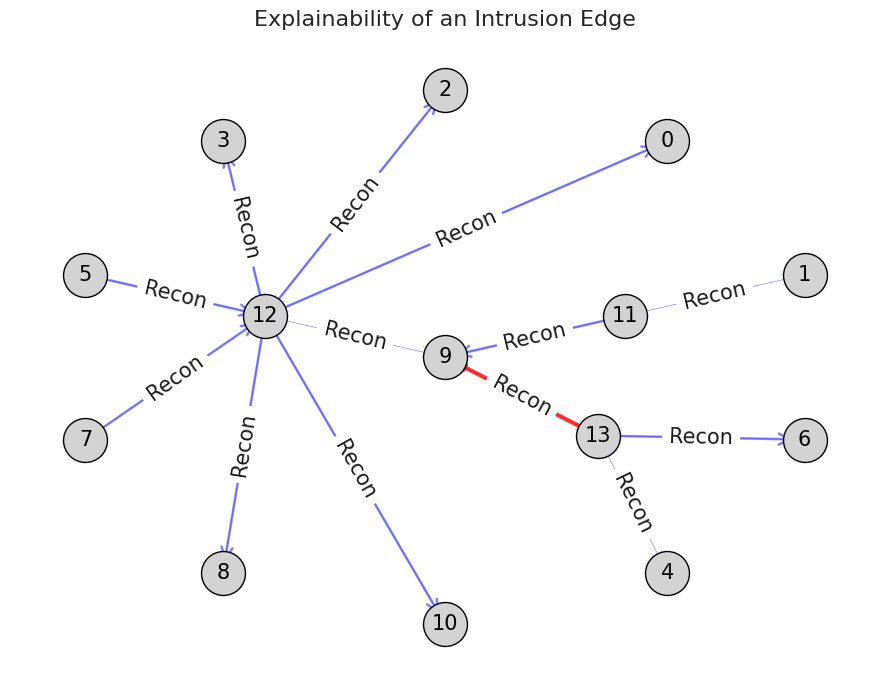

In [122]:
#for pg
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

G_plot=nx_graph_intrusion

edge_labels = {(u, v): d['label'] for u, v, d in G_plot.edges(data=True)}

# === Use graphviz layout via pydot ===
pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout

# === Plotting ===
plt.figure(figsize=(9, 7))
plt.title("Explainability of an Intrusion Edge", fontsize=16)

# Base edges with curve
nx.draw_networkx_edges(
    G_plot,
    pos,
    width= attck_edge_mask*2,
    alpha=0.5,
    edge_color='blue',
    arrows=True,
    arrowstyle='->',  # triangle arrow
    arrowsize=20,
    # connectionstyle='arc3,rad=0.08'
)

# Highlight one edge
nx.draw_networkx_edges(
    G_plot,
    pos,
    edgelist=[orange_edge],
    width=3,
    alpha=0.8,
    edge_color='red',
    # connectionstyle='arc3,rad=0.08'
)

# Nodes
nx.draw_networkx_nodes(
    G_plot,
    pos,
    node_size=1000,
    node_color='lightgray',
    edgecolors='black'
)

# Node labels
nx.draw_networkx_labels(
    G_plot,
    pos,
    font_size=15,
    font_color='black'
)

# Transparent edge labels
transparent_black = mcolors.to_rgba('black', alpha=0.9)

nx.draw_networkx_edge_labels(
    G_plot,
    pos,
    edge_labels=edge_labelss,
    font_color=transparent_black,
    font_size=15
)

plt.axis('off')
plt.tight_layout()
plt.savefig("/scratch/kc01/na3038/TrainedModels/intrusion_graph_layout.png", bbox_inches='tight')
plt.show()


/jobfs/145257347.gadi-pbs/ipykernel_3992057/3149673254.py:11: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout


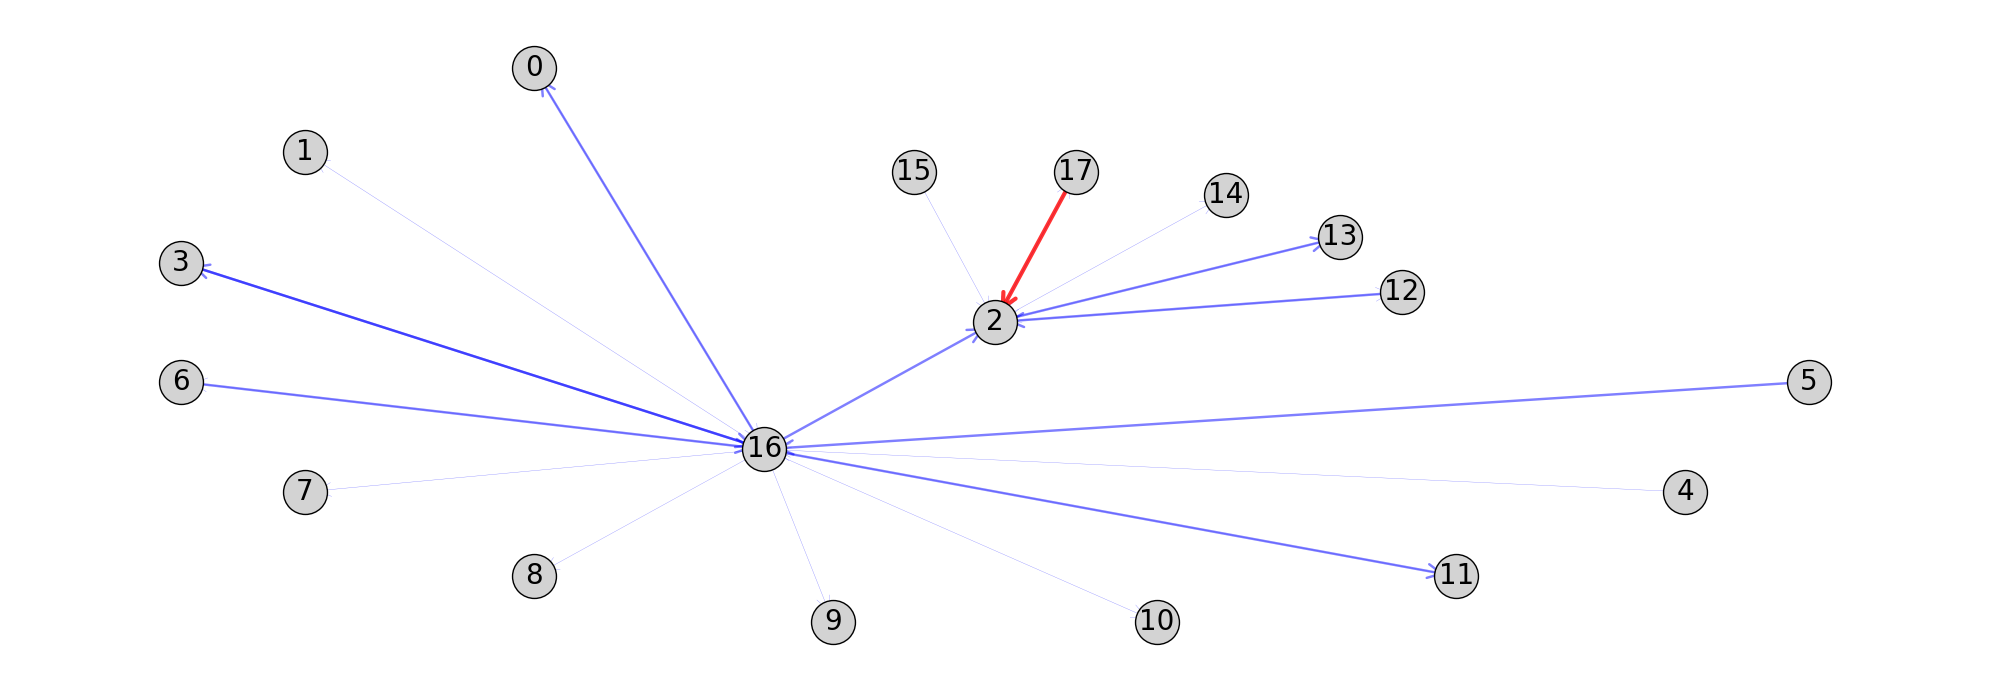

In [96]:
#for pg
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

G_plot=nx_graph_intrusion

edge_labels = {(u, v): d['label'] for u, v, d in G_plot.edges(data=True)}

# === Use graphviz layout via pydot ===
pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout

# === Plotting ===
plt.figure(figsize=(20, 7))
# plt.title("Explainability of an Intrusion Edge", fontsize=16)

# Base edges with curve
nx.draw_networkx_edges(
    G_plot,
    pos,
    width= attck_edge_mask*2,
    alpha=0.5,
    edge_color='blue',
    arrows=True,
    arrowstyle='->',  # triangle arrow
    arrowsize=25,
    # connectionstyle='arc3,rad=0.08'
)

# Highlight one edge
nx.draw_networkx_edges(
    G_plot,
    pos,
    edgelist=[orange_edge],
    width=3,
    alpha=0.8,
    edge_color='red',
    arrowstyle='->',  # triangle arrow
    arrowsize=25,
    # connectionstyle='arc3,rad=0.08'
)

# Nodes
nx.draw_networkx_nodes(
    G_plot,
    pos,
    node_size=1000,
    node_color='lightgray',
    edgecolors='black'
)

# Node labels
nx.draw_networkx_labels(
    G_plot,
    pos,
    font_size=20,
    font_color='black'
)

# Transparent edge labels
transparent_black = mcolors.to_rgba('black', alpha=0.9)

# nx.draw_networkx_edge_labels(
#     G_plot,
#     pos,
#     edge_labels=edge_labelss,
#     font_color=transparent_black,
#     font_size=20
# )

plt.axis('off')
plt.tight_layout()
# plt.savefig("/scratch/kc01/na3038/TrainedModels/intrusion_graph_layout.png", bbox_inches='tight')
plt.show()


In [391]:
u=orange_edge[0]
v=orange_edge[1]
for component in nx.weakly_connected_components(nx_graph_intrusion):
    if u in component and v in component:
            nodes_to_keep = component
            break
print(len(nodes_to_keep))
#             break

G_nx_sub = G_nx_simple.subgraph(nodes_to_keep).copy()

2


In [374]:
nx_graph_intrusion

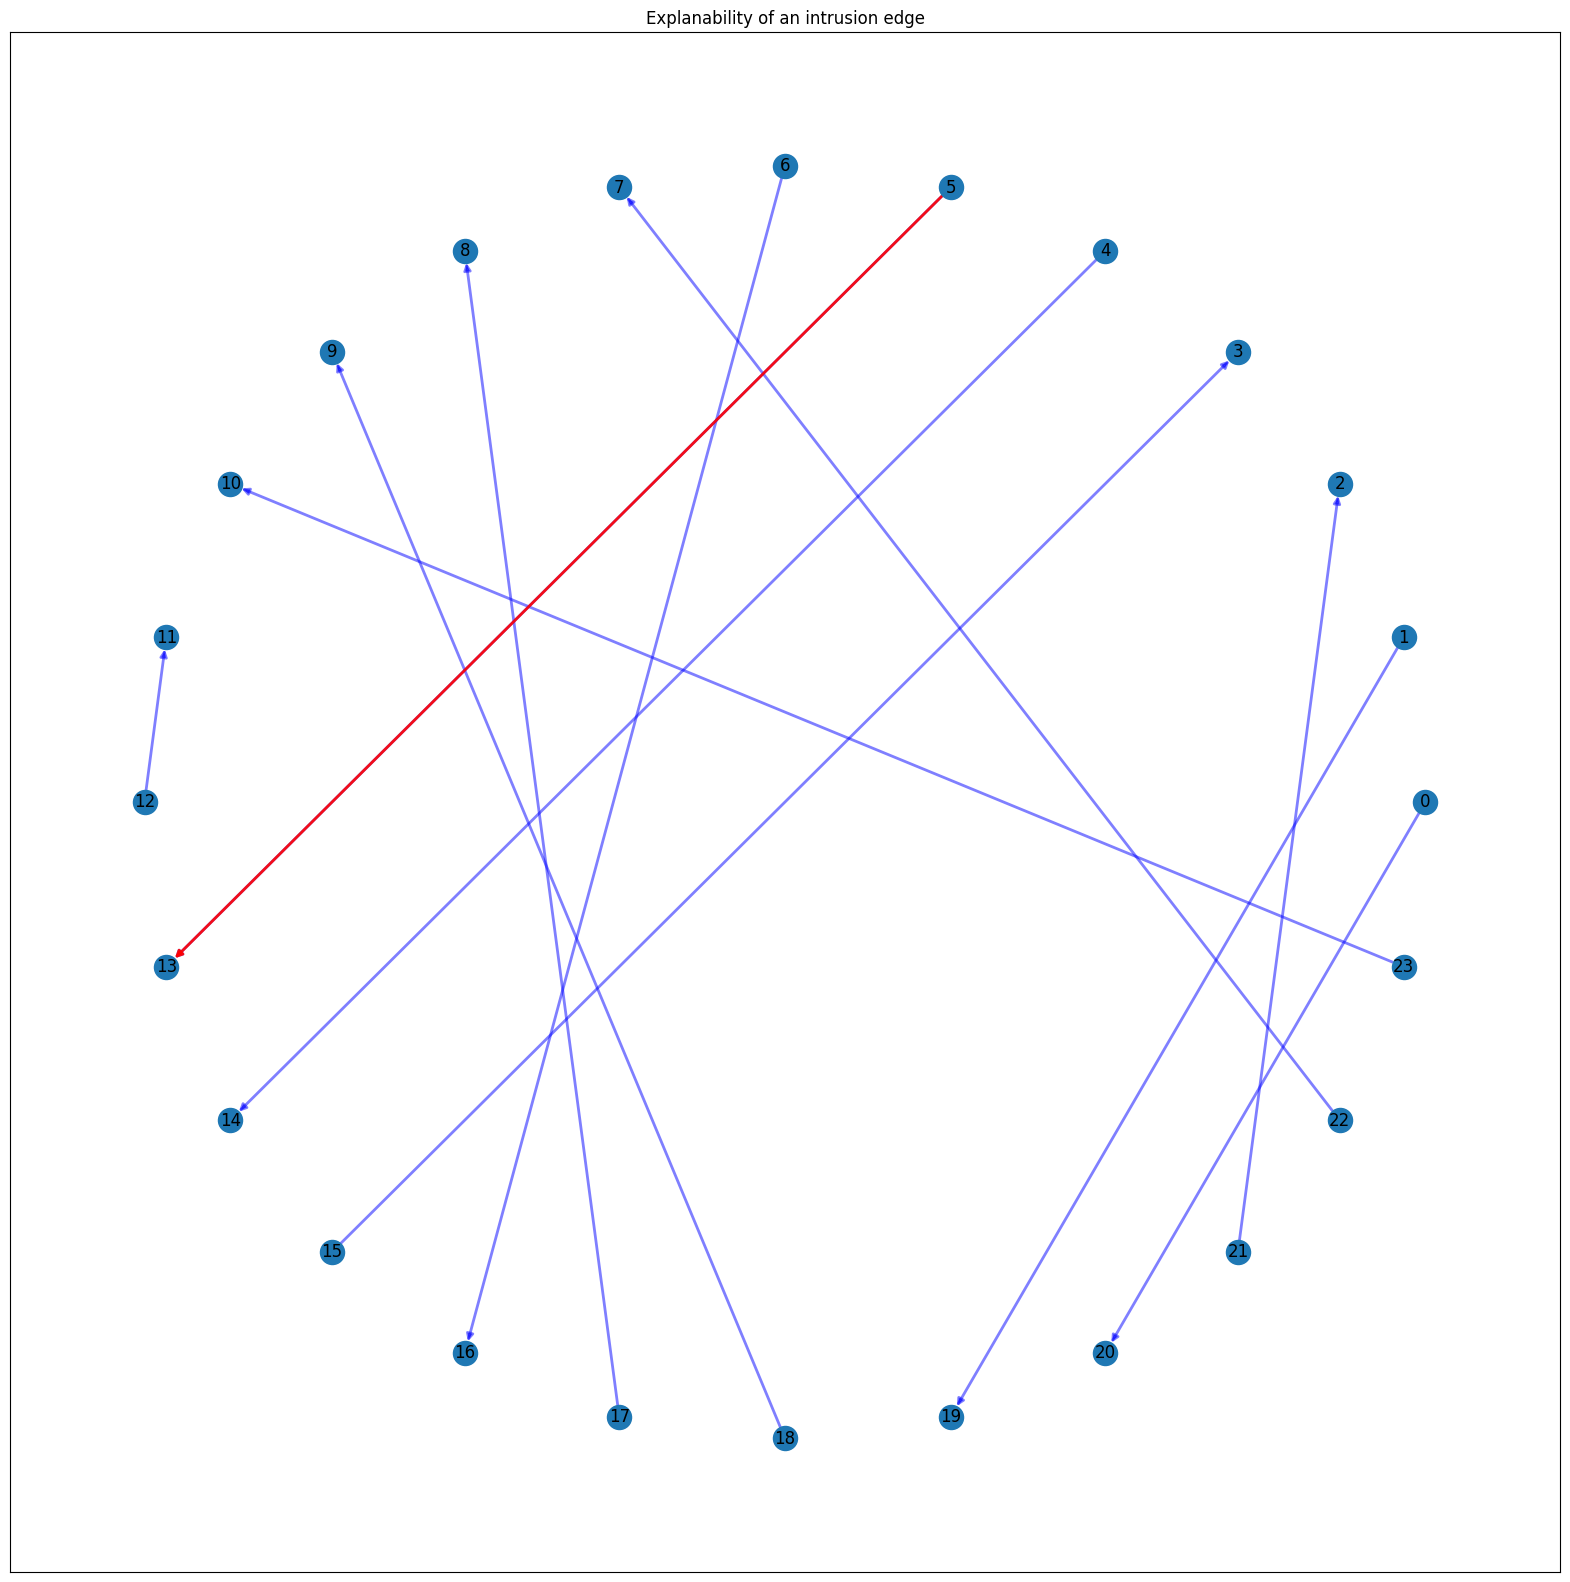

In [392]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[20,20])
plt.title("Explanability of an intrusion edge")
plot_graph= nx_graph_intrusion
pos = nx.circular_layout(plot_graph)

nx.draw_networkx_edges(plot_graph, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(plot_graph, pos)
nx.draw_networkx_labels(plot_graph, pos)

nx.draw_networkx_edges(
    plot_graph,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

# nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

/jobfs/144673024.gadi-pbs/ipykernel_1497975/308239378.py:21: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout


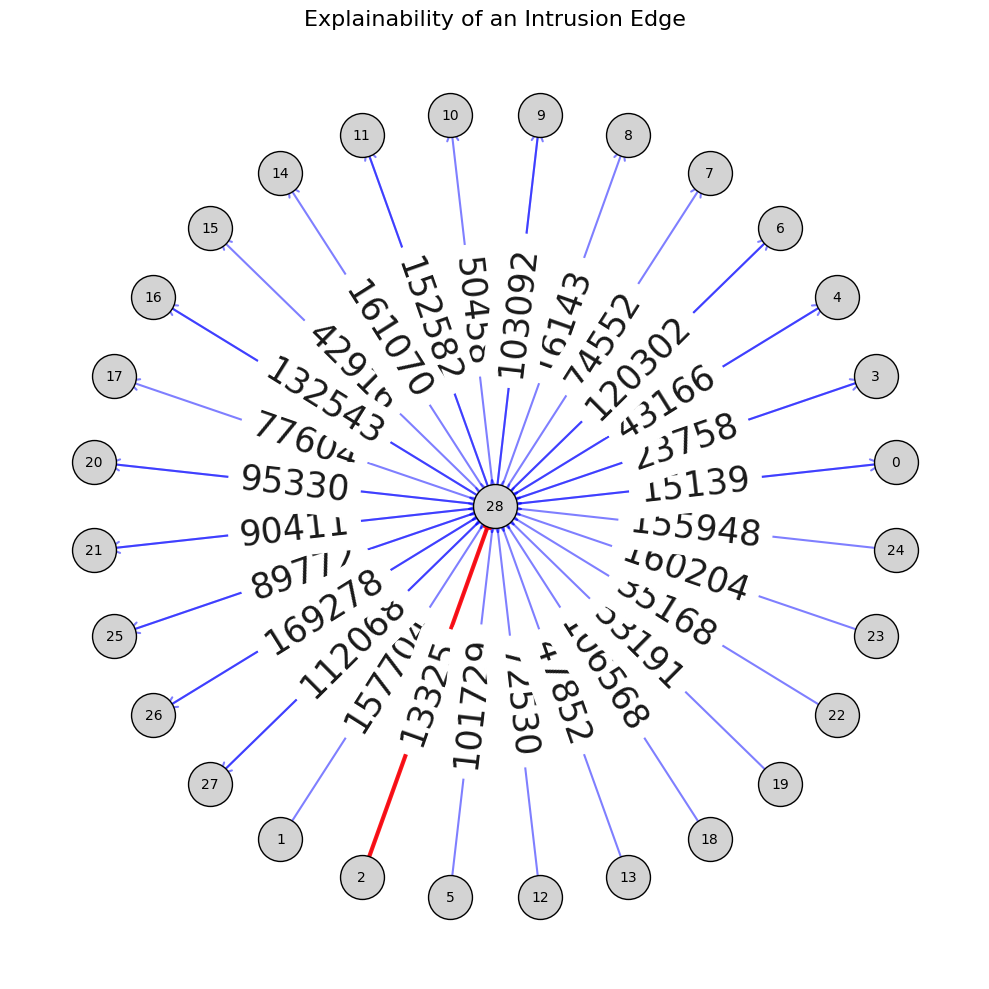

In [100]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === Sample Graph Construction ===
# G = nx.MultiDiGraph()

# G.add_nodes_from(['Attacker', 'Gateway', 'Victim1', 'Victim2', 'Victim3'])

# G.add_edge('Attacker', 'Gateway', label='intrusion')
# G.add_edge('Gateway', 'Victim1', label='scan')
# G.add_edge('Gateway', 'Victim2', label='exploit')
# G.add_edge('Gateway', 'Victim3', label='connect')
# G.add_edge('Attacker', 'Victim3', label='secondary path')
G_plot=nx_graph_intrusion

# highlight_edge = ('Attacker', 'Gateway')
edge_labels = {(u, v): d['label'] for u, v, d in G_plot.edges(data=True)}

# === Use graphviz layout via pydot ===
pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout

# === Plotting ===
plt.figure(figsize=(10, 10))
plt.title("Explainability of an Intrusion Edge", fontsize=16)

# Base edges with curve
nx.draw_networkx_edges(
    G_plot,
    pos,
    width=1.5,
    alpha=0.5,
    edge_color='blue',
    arrows=True,
    arrowstyle='->',  # triangle arrow
    arrowsize=20,
    # connectionstyle='arc3,rad=0.08'
)

# Highlight one edge
nx.draw_networkx_edges(
    G_plot,
    pos,
    edgelist=[orange_edge],
    width=3,
    alpha=0.9,
    edge_color='red',
    # connectionstyle='arc3,rad=0.08'
)

# Nodes
nx.draw_networkx_nodes(
    G_plot,
    pos,
    node_size=1000,
    node_color='lightgray',
    edgecolors='black'
)

# Node labels
nx.draw_networkx_labels(
    G_plot,
    pos,
    font_size=10,
    font_color='black'
)

# Transparent edge labels
transparent_black = mcolors.to_rgba('black', alpha=0.9)

nx.draw_networkx_edge_labels(
    G_plot,
    pos,
    edge_labels=edge_labelss,
    font_color=transparent_black,
    font_size=25
)

plt.axis('off')
plt.tight_layout()
plt.savefig("intrusion_graph_layout.pdf", dpi=300, bbox_inches='tight')
plt.show()


/jobfs/144673024.gadi-pbs/ipykernel_1497975/1967395664.py:22: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout


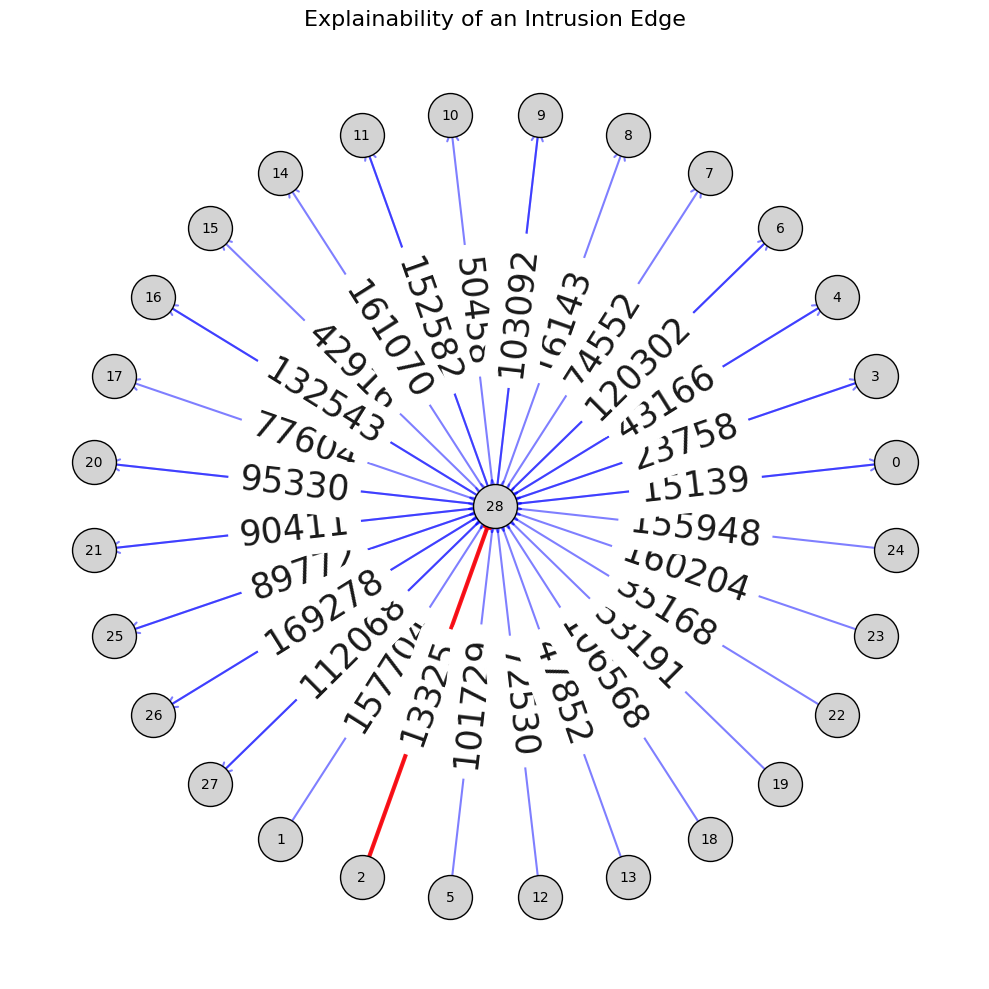

In [212]:
#for pg
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === Sample Graph Construction ===
# G = nx.MultiDiGraph()

# G.add_nodes_from(['Attacker', 'Gateway', 'Victim1', 'Victim2', 'Victim3'])

# G.add_edge('Attacker', 'Gateway', label='intrusion')
# G.add_edge('Gateway', 'Victim1', label='scan')
# G.add_edge('Gateway', 'Victim2', label='exploit')
# G.add_edge('Gateway', 'Victim3', label='connect')
# G.add_edge('Attacker', 'Victim3', label='secondary path')
G_plot=nx_graph_intrusion

# highlight_edge = ('Attacker', 'Gateway')
edge_labels = {(u, v): d['label'] for u, v, d in G_plot.edges(data=True)}

# === Use graphviz layout via pydot ===
pos = nx.nx_pydot.graphviz_layout(G_plot, prog='twopi')  # Radial layout

# === Plotting ===
plt.figure(figsize=(10, 10))
plt.title("Explainability of an Intrusion Edge", fontsize=16)

# Base edges with curve
nx.draw_networkx_edges(
    G_plot,
    pos,
    width=1.5,
    alpha=0.5,
    edge_color='blue',
    arrows=True,
    arrowstyle='->',  # triangle arrow
    arrowsize=20,
    # connectionstyle='arc3,rad=0.08'
)

# Highlight one edge
nx.draw_networkx_edges(
    G_plot,
    pos,
    edgelist=[orange_edge],
    width=3,
    alpha=0.9,
    edge_color='red',
    # connectionstyle='arc3,rad=0.08'
)

# Nodes
nx.draw_networkx_nodes(
    G_plot,
    pos,
    node_size=1000,
    node_color='lightgray',
    edgecolors='black'
)

# Node labels
nx.draw_networkx_labels(
    G_plot,
    pos,
    font_size=10,
    font_color='black'
)

# Transparent edge labels
transparent_black = mcolors.to_rgba('black', alpha=0.9)

nx.draw_networkx_edge_labels(
    G_plot,
    pos,
    edge_labels=edge_labelss,
    font_color=transparent_black,
    font_size=25
)

plt.axis('off')
plt.tight_layout()
plt.savefig("intrusion_graph_layout.pdf", dpi=300, bbox_inches='tight')
plt.show()


# Evaluate Explainer

In [19]:
actual

array(['Reconnaissance', 'Reconnaissance', 'Reconnaissance', ...,
       'Reconnaissance', 'Reconnaissance', 'Benign'], dtype=object)

In [54]:
def train_and_test(explainer_name, ratio_perc_to_keep,sorted_list, class_idx):
    selected_samples = sorted_list[:len(sorted_list)*ratio_perc_to_keep//100]

    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())
    class_weights = th.FloatTensor(class_weights).cuda()
    criterion = nn.CrossEntropyLoss(weight = class_weights)

    nfeats = G.ndata['h'][:, :, selected_samples]
    efeats = G.edata['h'][:, :, selected_samples]

    edge_label = G.edata['label']
    train_mask = G.edata['train_mask']

    model = Model(nfeats.shape[2], 128, nfeats.shape[2], F.relu, 0.2).cuda()
    opt = th.optim.Adam(model.parameters())

    # train_losses = []
    for epoch in range(1,200):
        pred = model(G, nfeats, efeats).cuda()
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        # train_losses.append(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()

    node_features_test = G_test.ndata['feature'][:, :, selected_samples]
    edge_features_test = G_test.edata['h'][:, :, selected_samples]
    model.eval()
    test_pred = model(G_test, node_features_test, edge_features_test)
    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    report = classification_report(le.transform(actual), test_pred, output_dict=True) #labels=[class_idx]

    # Extract class 0 metrics
    class_metrics = report[str(class_idx)]

    del model,nfeats,efeats
    return {
        'dataset': ratio_perc_to_keep,
        'model': explainer_name,
        'f1_macro': class_metrics['f1-score'],
        'precision': class_metrics['precision'],
        'recall': class_metrics['recall']
    }

In [55]:
sorted_items_pg = {0: [6, 5, 0, 3, 2, 1, 7, 4], 1: [0, 3, 4, 2, 7, 1, 6, 5], 2: [5, 7, 4, 3, 0, 1, 2, 6], 3: [3, 5, 0, 1, 4, 7, 6, 2]}
# {0: [0, 6, 3, 5, 1, 2, 4, 7], 1: [2, 4, 0, 1, 5, 7, 3, 6], 2: [4, 7, 0, 1, 5, 3, 6, 2], 3: [1, 7, 6, 2, 0, 5, 3, 4]}
# {0: [7, 6, 1, 4, 3, 2, 0, 5], 1: [0, 3, 2, 4, 7, 1, 5, 6], 2: [7, 4, 5, 6, 3, 1, 2, 0], 3: [2, 0, 1, 6, 4, 5, 3, 7]}
# {0: [3, 1, 0, 4, 6, 2, 5, 7], 1: [5, 7, 0, 3, 1, 4, 6, 2], 2: [1, 4, 7, 0, 3, 5, 6, 2], 3: [7, 0, 1, 6, 3, 2, 5, 4]}
sorted_items_gnn = {0: [6, 1, 2, 5, 3, 0, 7, 4], 1: [2, 3, 4, 6, 0, 5, 7, 1], 2: [4, 7, 6, 1, 3, 2, 0, 5], 3: [6, 3, 4, 1, 0, 5, 2, 7]}
# {0: [2, 1, 6, 7, 3, 4, 0, 5], 1: [2, 1, 5, 3, 0, 7, 6, 4], 2: [2, 1, 3, 7, 0, 5, 4, 6], 3: [7, 6, 3, 5, 1, 2, 4, 0]}
# {0: [0, 7, 5, 6, 4, 3, 1, 2], 1: [0, 3, 2, 1, 4, 5, 6, 7], 2: [1, 4, 0, 5, 6, 7, 3, 2], 3: [3, 6, 4, 0, 7, 1, 2, 5]}
# {0: [5, 1, 4, 7, 3, 6, 2, 0], 1: [5, 2, 4, 3, 0, 7, 6, 1], 2: [2, 4, 3, 5, 0, 7, 1, 6], 3: [4, 7, 1, 3, 2, 5, 6, 0]}

In [56]:
last = {
    0: {
        "Precision": 0.2524,
        "Recall": 0.8582,
        "F1-score": 0.3901 
    },
    1: {
        "Precision":0.7815,
        "Recall": 0.9794,
        "F1-score": 0.8693
    },
    2: {
        "Precision": 0.9936,
        "Recall": 0.8584,
        "F1-score": 0.9211
    },
   3: {
        "Precision": 0.2995,
        "Recall": 0.7315,
        "F1-score": 0.4250
    }
}

In [ ]:
# #last
# # # acc_ref= 0.994
# # f1_macro_ref=0.37
# # precision_ref=0.23
# # recall_ref=0.99

# 0.014966114889830351 seconds
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.2524    0.8582    0.3901    0.8582    8185      
# DoS/DDoS       0.7815    0.9794    0.8693    0.9794    67978     
# Reconnaissance 0.9936    0.8584    0.9211    0.8584    282778    
# Theft          0.2995    0.7315    0.4250    0.7315    1110      

# Overall Accuracy:
# Accuracy: 0.8809

# Weighted Averages:
# {'precision': 0.9345463099505048, 'recall': 0.8808835414982877, 'f1-score': 0.89770795496148, 'support': 360051.0}

## For Benign

In [93]:
str(le.inverse_transform([0])[0])

'Benign'

======Class type explaining: ['Benign'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:23<01:11, 23.79s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/

Running 40


 50%|█████     | 2/4 [00:47<00:47, 23.89s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:11<00:23, 23.92s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 20


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|██▌       |

Running 40


 50%|█████     | 2/4 [00:47<00:47, 23.89s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:11<00:23, 23.92s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


100%|██████████| 4/4 [01:35<00:00, 23.95s/it]


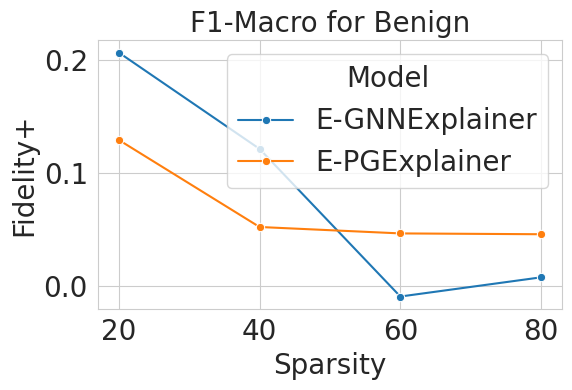

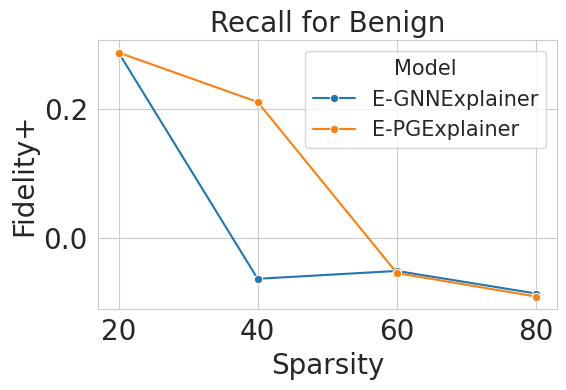

======Class type explaining: ['DoS/DDoS'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:23<01:11, 23.76s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/

Running 40


 50%|█████     | 2/4 [00:47<00:47, 23.88s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:11<00:23, 23.92s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 20


 25%|██▌       | 1/4 [00:23<01:11, 23.76s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 40


 50%|█████     | 2/4 [00:47<00:47, 23.88s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:11<00:23, 23.91s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


100%|██████████| 4/4 [01:35<00:00, 23.93s/it]


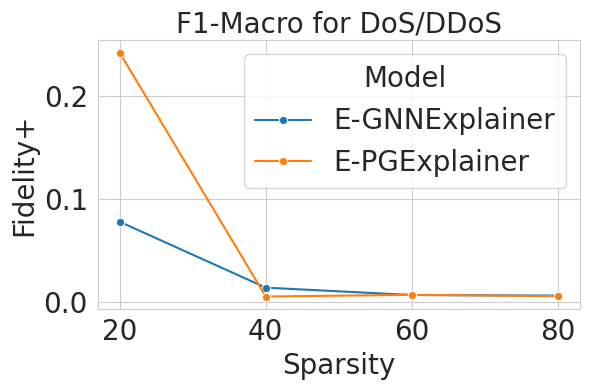

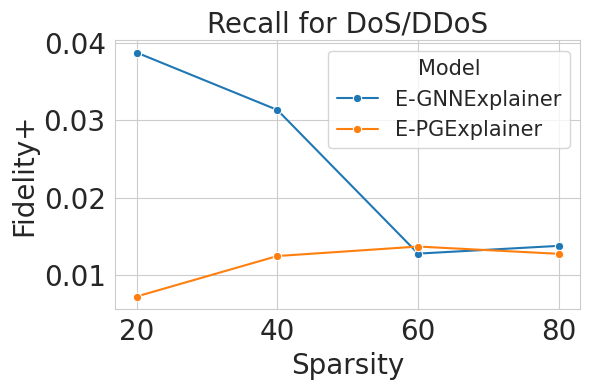

======Class type explaining: ['Reconnaissance'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:23<01:11, 23.77s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/

Running 40


 50%|█████     | 2/4 [00:47<00:47, 23.88s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:11<00:23, 23.92s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 20


 25%|██▌       | 1/4 [00:23<01:11, 23.77s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 40


 50%|█████     | 2/4 [00:47<00:47, 23.88s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:11<00:23, 23.91s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


100%|██████████| 4/4 [01:35<00:00, 23.94s/it]


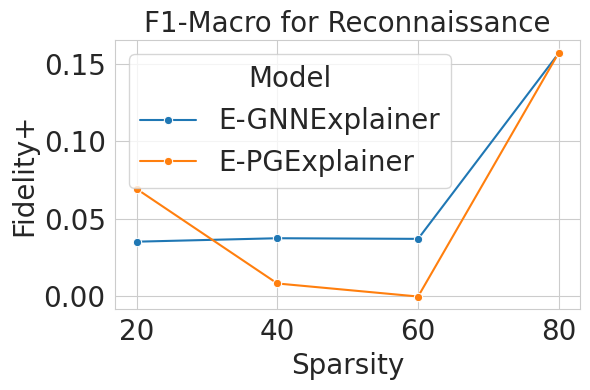

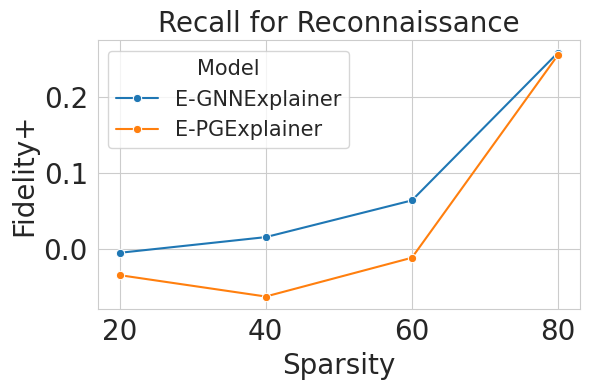

======Class type explaining: ['Theft'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:23<01:11, 23.75s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/

Running 40


 50%|█████     | 2/4 [00:47<00:47, 23.87s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:11<00:23, 23.91s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 20


 25%|██▌       | 1/4 [00:23<01:11, 23.76s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 40


 50%|█████     | 2/4 [00:47<00:47, 23.87s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:11<00:23, 23.91s/it]/jobfs/145257347.gadi-pbs/ipykernel_3992057/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


100%|██████████| 4/4 [01:35<00:00, 23.93s/it]


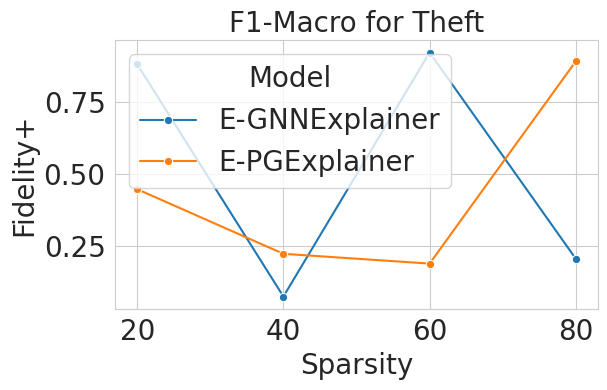

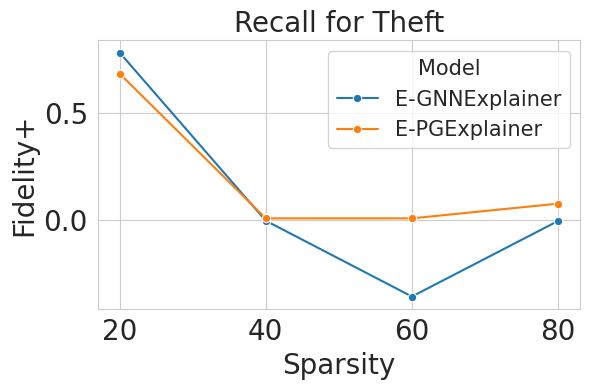

In [57]:
for class_idx in range(4):
  # class_idx = 0
  print("======Class type explaining:", le.inverse_transform([class_idx]),"=============")
  #last
  # acc_ref= 0.994
  f1_macro_ref=last[class_idx]["F1-score"]
  precision_ref=last[class_idx]["Precision"]
  recall_ref=last[class_idx]["Recall"]

  # [('TCP_FLAGS', 0.5615923091769218), ('PROTOCOL', 0.2268944913521409), ('L7_PROTO', 0.02550065517425537), ('FLOW_DURATION_MILLISECONDS', -0.014227990433573723), ('OUT_BYTES', -0.08358267816365697), ('IN_BYTES', -0.426235506311059), ('IN_PKTS', -0.43372365944087504), ('OUT_PKTS', -0.4708433669991791)]
  sorted_list_gnn = sorted_items_gnn[class_idx] #[k for k, v in sorted_items_gnn[class_idx]]
  # sorted_list_gnn

  #for PG
  sorted_list_pg = sorted_items_pg[class_idx] #[k for k, v in sorted_items_pg[class_idx]] #[2,1,4,5,3,0,6,7]
  # sorted_list_pg

  df_results = []
  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-GNNExplainer", i, sorted_list_gnn, class_idx))


  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-PGExplainer", i, sorted_list_pg,class_idx))

  pdf_results = pd.DataFrame(df_results)
  # pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
  pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
  pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
  pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

  # pdf_results

  plt.figure(figsize=(6, 4))
  sns.set_style(style='whitegrid')

  ax = sns.lineplot(
    data=pdf_results,
    x='dataset',
    y='f1_macro_drop',
    marker="o",
    hue="model"
  )

  ax.set(
    xlabel="Sparsity",
    ylabel="Fidelity+",
    title=f"F1-Macro for {le.inverse_transform([class_idx])[0]}"
  )

  # Set font sizes
  ax.set_title(ax.get_title(), fontsize=20)
  ax.set_xlabel(ax.get_xlabel(), fontsize=20)
  ax.set_ylabel(ax.get_ylabel(), fontsize=20)
  ax.tick_params(axis='both', labelsize=20)
  ax.legend(title='Model', title_fontsize=20, fontsize=20)

  plt.tight_layout()
  plt.show()
  fig = ax.get_figure()


  plt.figure(figsize=(6, 4))
  sns.set_style(style='whitegrid')

  ax = sns.lineplot(
    data=pdf_results,
    x='dataset',
    y='recall_drop',
    marker="o",
    hue="model"
  )

  ax.set(
    xlabel="Sparsity",
    ylabel="Fidelity+",
    title=f"Recall for {le.inverse_transform([class_idx])[0]}"
  )

  # Set font sizes again
  ax.set_title(ax.get_title(), fontsize=20)
  ax.set_xlabel(ax.get_xlabel(), fontsize=20)
  ax.set_ylabel(ax.get_ylabel(), fontsize=20)
  ax.tick_params(axis='both', labelsize=20)
  ax.legend(title='Model', title_fontsize=15, fontsize=15)

  plt.tight_layout()
  plt.savefig(f"/scratch/kc01/na3038/TrainedModels/eval_{class_idx}.png", bbox_inches='tight')
  plt.show()


#this is the final result

In [ ]:
for class_idx in [3]:
  # class_idx = 0
  print("======Class type explaining:", le.inverse_transform([class_idx]),"=============")
  #last
  # acc_ref= 0.994
  f1_macro_ref=last[class_idx]["F1-score"]
  precision_ref=last[class_idx]["Precision"]
  recall_ref=last[class_idx]["Recall"]

  # [('TCP_FLAGS', 0.5615923091769218), ('PROTOCOL', 0.2268944913521409), ('L7_PROTO', 0.02550065517425537), ('FLOW_DURATION_MILLISECONDS', -0.014227990433573723), ('OUT_BYTES', -0.08358267816365697), ('IN_BYTES', -0.426235506311059), ('IN_PKTS', -0.43372365944087504), ('OUT_PKTS', -0.4708433669991791)]
  sorted_list_gnn = sorted_items_gnn[class_idx] #[k for k, v in sorted_items_gnn[class_idx]]
  # sorted_list_gnn

  #for PG
  sorted_list_pg = sorted_items_pg[class_idx] #[k for k, v in sorted_items_pg[class_idx]] #[2,1,4,5,3,0,6,7]
  # sorted_list_pg

  df_results = []
  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-GNNExplainer", i, sorted_list_gnn, class_idx))


  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-PGExplainer", i, sorted_list_pg,class_idx))

  pdf_results = pd.DataFrame(df_results)
  # pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
  pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
  pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
  pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

  # pdf_results

  plt.figure(figsize=(6, 4))
  sns.set_style(style='whitegrid')

  ax = sns.lineplot(
    data=pdf_results,
    x='dataset',
    y='f1_macro_drop',
    marker="o",
    hue="model"
  )

  ax.set(
    xlabel="Sparsity",
    ylabel="Fidelity+",
    title=f"F1-Macro for {le.inverse_transform([class_idx])[0]}"
  )

  # Set font sizes
  ax.set_title(ax.get_title(), fontsize=20)
  ax.set_xlabel(ax.get_xlabel(), fontsize=20)
  ax.set_ylabel(ax.get_ylabel(), fontsize=20)
  ax.tick_params(axis='both', labelsize=20)
  ax.legend(title='Model', title_fontsize=20, fontsize=20)

  plt.tight_layout()
  plt.show()
  fig = ax.get_figure()


  plt.figure(figsize=(7, 6))
  sns.set_style(style='whitegrid')

  ax = sns.lineplot(
    data=pdf_results,
    x='dataset',
    y='recall_drop',
    marker="o",
    hue="model"
  )

  ax.set(
    xlabel="Sparsity",
    ylabel="Fidelity+",
    title=f"Recall for {le.inverse_transform([class_idx])[0]}"
  )

  # Set font sizes again
  ax.set_title(ax.get_title(), fontsize=20)
  ax.set_xlabel(ax.get_xlabel(), fontsize=20)
  ax.set_ylabel(ax.get_ylabel(), fontsize=20)
  ax.tick_params(axis='both', labelsize=20)
  ax.legend(title='Model', title_fontsize=15, fontsize=15)

  plt.tight_layout()
  plt.savefig(f"/scratch/kc01/na3038/TrainedModels/eval_new_{class_idx}.png", bbox_inches='tight')
  plt.show()


#this is the final result

======Class type explaining: ['Theft'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:27<01:23, 27.67s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])


Running 40


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 50%|█████     | 2/4 [00:55<00:55, 27.82s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])


Running 60


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 75%|███████▌  | 3/4 [01:23<00:27, 27.87s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])


Running 80


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])


Running 20


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:27<01:22, 27.65s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])


Running 40


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


======Class type explaining: ['Reconnaissance'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 25%|██▌       | 1/4 [00:27<01:22, 27.64s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/

Running 40


 50%|█████     | 2/4 [00:55<00:55, 27.79s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:23<00:27, 27.84s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 20


 25%|██▌       | 1/4 [00:27<01:22, 27.62s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 40


 50%|█████     | 2/4 [00:55<00:55, 27.78s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 60


 75%|███████▌  | 3/4 [01:23<00:27, 27.83s/it]/jobfs/145224672.gadi-pbs/ipykernel_3653954/3939805556.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask] ,edge_label[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Running 80


100%|██████████| 4/4 [01:51<00:00, 27.86s/it]


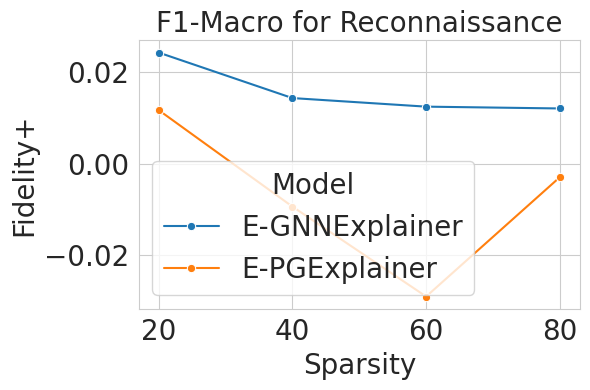

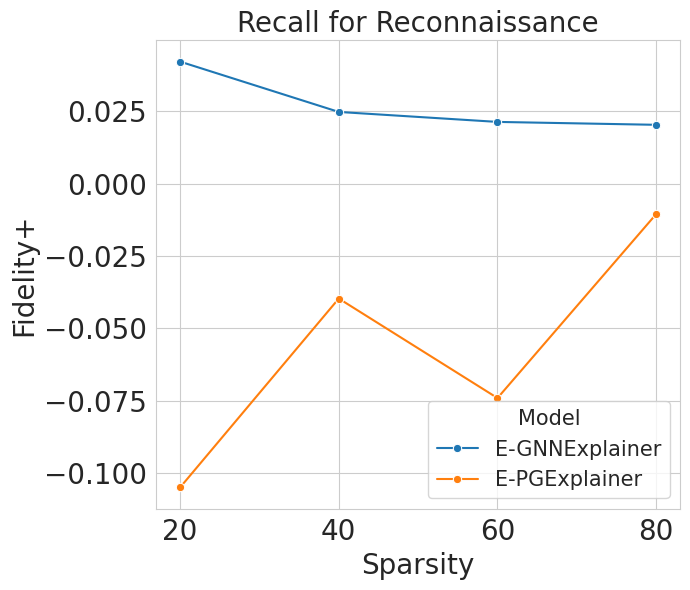

In [43]:
for class_idx in [2]:
  # class_idx = 0
  print("======Class type explaining:", le.inverse_transform([class_idx]),"=============")
  #last
  # acc_ref= 0.994
  f1_macro_ref=last[class_idx]["F1-score"]
  precision_ref=last[class_idx]["Precision"]
  recall_ref=last[class_idx]["Recall"]

  # [('TCP_FLAGS', 0.5615923091769218), ('PROTOCOL', 0.2268944913521409), ('L7_PROTO', 0.02550065517425537), ('FLOW_DURATION_MILLISECONDS', -0.014227990433573723), ('OUT_BYTES', -0.08358267816365697), ('IN_BYTES', -0.426235506311059), ('IN_PKTS', -0.43372365944087504), ('OUT_PKTS', -0.4708433669991791)]
  sorted_list_gnn = sorted_items_gnn[class_idx] #[k for k, v in sorted_items_gnn[class_idx]]
  # sorted_list_gnn

  #for PG
  sorted_list_pg = sorted_items_pg[class_idx] #[k for k, v in sorted_items_pg[class_idx]] #[2,1,4,5,3,0,6,7]
  # sorted_list_pg

  df_results = []
  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-GNNExplainer", i, sorted_list_gnn, class_idx))


  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-PGExplainer", i, sorted_list_pg,class_idx))

  pdf_results = pd.DataFrame(df_results)
  # pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
  pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
  pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
  pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

  # pdf_results

  plt.figure(figsize=(6, 4))
  sns.set_style(style='whitegrid')

  ax = sns.lineplot(
    data=pdf_results,
    x='dataset',
    y='f1_macro_drop',
    marker="o",
    hue="model"
  )

  ax.set(
    xlabel="Sparsity",
    ylabel="Fidelity+",
    title=f"F1-Macro for {le.inverse_transform([class_idx])[0]}"
  )

  # Set font sizes
  ax.set_title(ax.get_title(), fontsize=20)
  ax.set_xlabel(ax.get_xlabel(), fontsize=20)
  ax.set_ylabel(ax.get_ylabel(), fontsize=20)
  ax.tick_params(axis='both', labelsize=20)
  ax.legend(title='Model', title_fontsize=20, fontsize=20)

  plt.tight_layout()
  plt.show()
  fig = ax.get_figure()


  plt.figure(figsize=(7, 6))
  sns.set_style(style='whitegrid')

  ax = sns.lineplot(
    data=pdf_results,
    x='dataset',
    y='recall_drop',
    marker="o",
    hue="model"
  )

  ax.set(
    xlabel="Sparsity",
    ylabel="Fidelity+",
    title=f"Recall for {le.inverse_transform([class_idx])[0]}"
  )

  # Set font sizes again
  ax.set_title(ax.get_title(), fontsize=20)
  ax.set_xlabel(ax.get_xlabel(), fontsize=20)
  ax.set_ylabel(ax.get_ylabel(), fontsize=20)
  ax.tick_params(axis='both', labelsize=20)
  ax.legend(title='Model', title_fontsize=15, fontsize=15)

  plt.tight_layout()
  plt.savefig(f"/scratch/kc01/na3038/TrainedModels/eval_new_{class_idx}.png", bbox_inches='tight')
  plt.show()


#this is the final result

In [82]:
for class_idx in range(1,4):
  # class_idx = 0
  print("======Class type explaining:", le.inverse_transform([class_idx]),"=============")
  #last
  # acc_ref= 0.994
  f1_macro_ref=last[class_idx]["F1-score"]
  precision_ref=last[class_idx]["Precision"]
  recall_ref=last[class_idx]["Recall"]

  # [('TCP_FLAGS', 0.5615923091769218), ('PROTOCOL', 0.2268944913521409), ('L7_PROTO', 0.02550065517425537), ('FLOW_DURATION_MILLISECONDS', -0.014227990433573723), ('OUT_BYTES', -0.08358267816365697), ('IN_BYTES', -0.426235506311059), ('IN_PKTS', -0.43372365944087504), ('OUT_PKTS', -0.4708433669991791)]
  sorted_list_gnn = sorted_items_gnn[class_idx] #[k for k, v in sorted_items_gnn[class_idx]]
  # sorted_list_gnn

  #for PG
  sorted_list_pg = sorted_items_pg[class_idx] #[k for k, v in sorted_items_pg[class_idx]] #[2,1,4,5,3,0,6,7]
  # sorted_list_pg

  df_results = []
  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-GNNExplainer", i, sorted_list_gnn, class_idx))


  for i in tqdm(range(20,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-PGExplainer", i, sorted_list_pg,class_idx))

  pdf_results = pd.DataFrame(df_results)
  # pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
  pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
  pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
  pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

  # pdf_results

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results,
      x='dataset',
      y='f1_macro_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
  plt.show()
  fig = ax.get_figure()

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
      x='dataset',
      y='recall_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
  ax1.legend(title='Model', fontsize=12)
  plt.show()
  fig = ax.get_figure()


======Class type explaining: ['DoS/DDoS'] =============


  0%|          | 0/4 [00:00<?, ?it/s]

Running 20


NameError: name 'number_of_classes' is not defined

In [ ]:
#20 min for one class eval generation

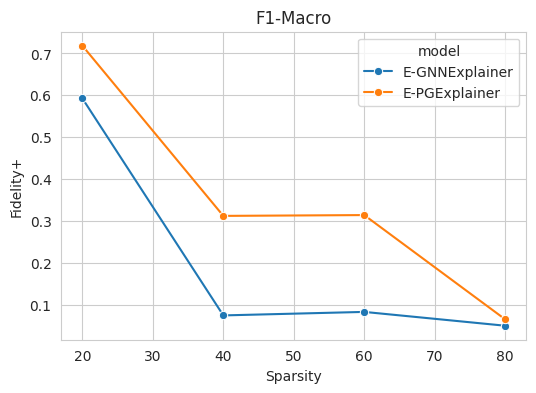

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='f1_macro_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
plt.show()
fig = ax.get_figure()

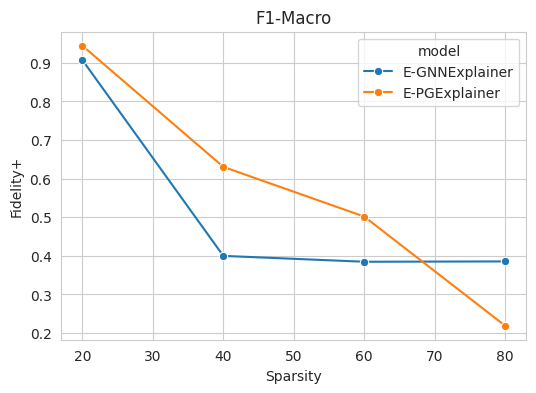

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='recall_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
plt.show()
fig = ax.get_figure()

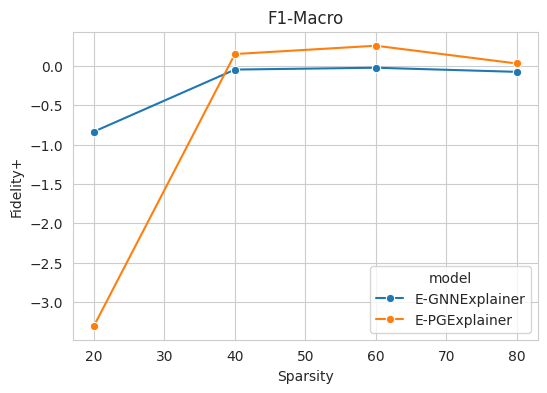

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='precision_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Precision")
plt.show()
fig = ax.get_figure()

# OvA Model


In [166]:
global emb
global score_global
emb ={key: [] for key in range(number_of_classes)}
score_global ={key: [] for key in range(number_of_classes)}

In [167]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(number_of_classes)])

    def apply_edges(self, edges, class_idx, test,apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        if apply_sigmoid:
            score = torch.sigmoid(logits) #logits[:,1] #torch.sigmoid(logits)[:,1]
        else:
            score = logits
        # score = logits
        if test:
            emb[class_idx]= th.cat([h_u, h_v], 1)
            score_global[class_idx] = score
        return {'score': score}
    def forward(self, graph, h,test,class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,test, apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,test,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, eweight=None, feature_weight=None, test=False,class_idx=None):
      if eweight != None:
            # apply eweight on the graph
            efe = []
            for i, x in enumerate(eweight):
                efe.append(list(th.Tensor.cpu(g.edata['h'][i][0]).detach().numpy() * th.Tensor.cpu(x).detach().numpy()))

            efe = th.FloatTensor(efe).cuda()
            efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
            g.edata['h'] = efe = efe
      if feature_weight != None:
          efe= []
          weights = th.tensor(feature_weight,device='cuda')
          # weights = weights.view(1, 1, -1)
          g.edata['h'] *= weights
          efe = g.edata['h']
          g.edata['h'] = efe = efe
          # efeats *= weights
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h,test,class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h,test)

In [168]:
from sklearn.utils import class_weight
class_weights_list = []
for i in range(number_of_classes):
    binary_labels = (G.edata['label'].cpu().numpy() == i).astype(int)
    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes= np.unique(binary_labels),
                                                  y= binary_labels)
    class_weights = th.FloatTensor(class_weights).cuda()
    class_weights_list.append(class_weights)
class_weights_list

[tensor([ 0.5119, 21.4980], device='cuda:0'),
 tensor([0.6166, 2.6442], device='cuda:0'),
 tensor([2.3198, 0.6374], device='cuda:0'),
 tensor([  0.5016, 156.9768], device='cuda:0')]

In [169]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        optimizer.zero_grad()
        selected_efeatures = efeats
        selected_nfeatures = nfeats

        # Forward pass
        outputs = model(graph, selected_nfeatures, selected_efeatures,class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        # pos_weight = class_weights_list[class_idx][0] / (class_weights_list[class_idx][1] + 1e-6)
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


0.2511199675500393
0.23660164698958397
0.2199547179043293
0.2075631059706211
0.1820817831903696
0.19906589947640896
0.20696398802101612


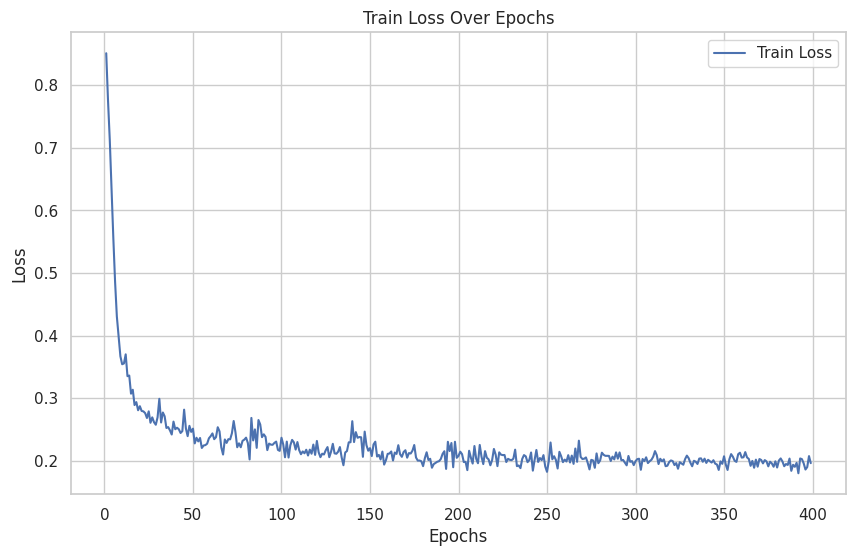

In [170]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(8, 128, 8, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

train_losses = []
for epoch in range(1,400):#400
    avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, number_of_classes)
    train_losses.append(avg_loss)
    if epoch % 50 == 0:
        print(avg_loss)

epochs = range(1, 400)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def predict_one_vs_all(model,graph,node_feat, edge_feat):
    model.eval()

    with th.no_grad():
        # Forward pass to get binary classifier outputs for all classes
        outputs = model(graph, nfeats, efeats,test = True)
        # new_df=outputs.cpu().detach().numpy()
        # new_df=pd.DataFrame(outputs.squeeze().cpu())
        # print(outputs.squeeze().shape)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes #, new_df

nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats) #, new_df
predicted_classes.unique()

tensor([0, 1, 2, 3], device='cuda:0')

In [171]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])
# 0.014568910002708435 seconds
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.2620    0.9973    0.4150    0.9973    8260      
# DDoS           0.3601    0.3731    0.3665    0.3731    34264     
# DoS            0.4091    0.6003    0.4866    0.6003    34136     
# Reconnaissance 0.9971    0.8485    0.9168    0.8485    282182    
# Theft          0.1839    0.4384    0.2591    0.4384    1218      

# Overall Accuracy:
# Accuracy: 0.7818

# Weighted Averages:
# {'precision': 0.8611295817591849, 'recall': 0.7817613731044826, 'f1-score': 0.8099282026322722, 'support': 360060.0}

Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.7391    0.5006    0.5969    0.5006    8178      
DoS/DDoS       0.7820    0.9800    0.8699    0.9800    68492     
Reconnaissance 0.9820    0.9267    0.9535    0.9267    282248    
Theft          0.1665    0.3380    0.2231    0.3380    1142      

Overall Accuracy:
Accuracy: 0.9253

Weighted Averages:
{'precision': 0.9358224704498279, 'recall': 0.9253152252402378, 'f1-score': 0.9272147369721423, 'support': 360060.0}


In [172]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.7391    0.5006    0.5969    0.5006    8178      
DoS/DDoS       0.7820    0.9800    0.8699    0.9800    68492     
Reconnaissance 0.9820    0.9267    0.9535    0.9267    282248    
Theft          0.1665    0.3380    0.2231    0.3380    1142      

Overall Accuracy:
Accuracy: 0.9253

Weighted Averages:
{'precision': 0.9358224704498279, 'recall': 0.9253152252402378, 'f1-score': 0.9272147369721423, 'support': 360060.0}


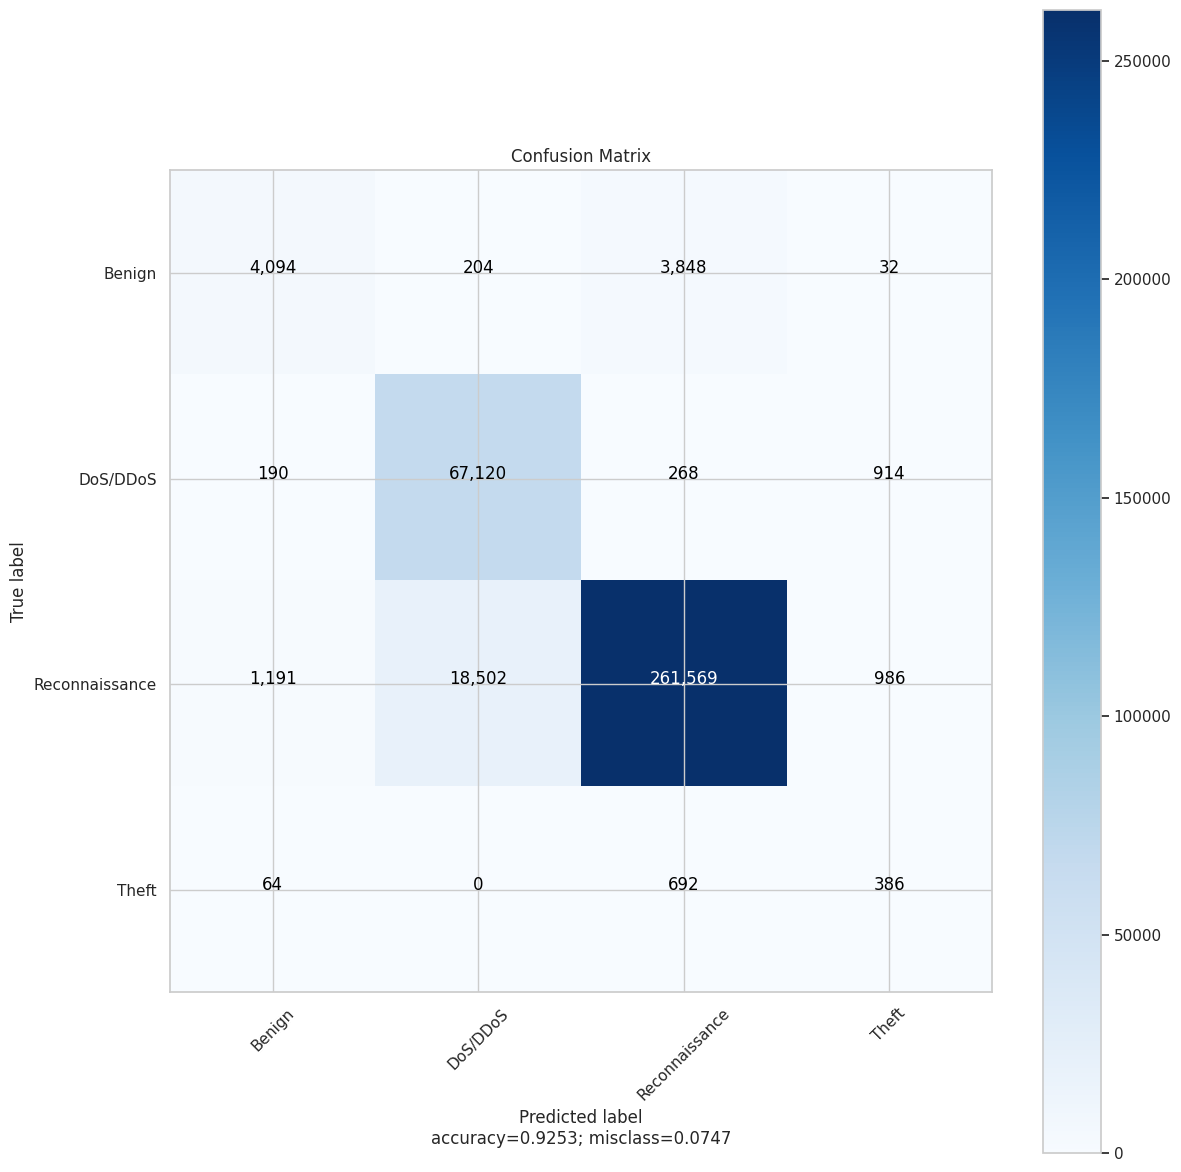

In [173]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual, le.inverse_transform(predicted_classes.cpu())),
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [ ]:
X = actual
y = le.inverse_transform(predicted_classes.cpu())
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# OvA - With Class wise features

In [32]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(4)])

    def apply_edges(self, edges, class_idx, apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        # if apply_sigmoid:
        #     score = logits[:,1] #torch.sigmoid(logits)[:,1]
        # else:
        #     score = logits
        score = logits
        return {'score': score}
    def forward(self, graph, h, class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None,class_idx=None):
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h, class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h)

In [33]:
class_weights_list = []
for i in range(4):
    binary_labels = (G.edata['label'].cpu().numpy() == i).astype(int)
    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes= np.unique(binary_labels),
                                                  y= binary_labels)
    class_weights = th.FloatTensor(class_weights).cuda()
    class_weights_list.append(class_weights)
    print(th.log(1 + class_weights_list[i][1]))
class_weights_list

tensor(3.1148, device='cuda:0')
tensor(1.2908, device='cuda:0')
tensor(0.4934, device='cuda:0')
tensor(5.0506, device='cuda:0')


[tensor([ 0.5119, 21.5296], device='cuda:0'),
 tensor([0.6171, 2.6357], device='cuda:0'),
 tensor([2.3132, 0.6379], device='cuda:0'),
 tensor([  0.5016, 155.1195], device='cuda:0')]

In [34]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes, selected_features_per_class):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        optimizer.zero_grad()
        selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
        selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

        # Forward pass
        outputs = model(graph, selected_nfeatures, selected_efeatures,class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        weight = th.log(1 + class_weights_list[class_idx][1]) #[class_weights_list[class_idx][1]]
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor(weight, device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


In [35]:
def predict_one_vs_all(model,graph,nfeats, efeats,selected_features_per_class):
    model.eval()

    with th.no_grad():
        outputs = []
        for class_idx in range(4):
          selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
          selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

          logits = model(graph, selected_nfeatures, selected_efeatures, class_idx=class_idx).cuda()

          outputs.append(logits)#torch.sigmoid(logits)[:,0]

        outputs = th.stack(outputs, dim=1)  # Shape: (num_nodes, num_classes)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes

# nfeats = G_test.ndata['feature']
# efeats = G_test.edata['h']
# predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats)
# predicted_classes.unique()

In [36]:
# selected_features_per_class=final_features
# for e -gnn
selected_features_per_class_gnn ={0: [2, 6, 4, 1, 5, 7, 0, 3], 1: [3, 5, 1, 6, 7, 0, 4, 2], 2: [1, 5, 6, 0, 7, 4, 2, 3], 3: [5, 3, 0, 4, 6, 1, 2, 7]}

#for e-pg
selected_features_per_class_pg = {0: [6, 5, 0, 3, 2, 1, 7, 4], 1: [0, 3, 4, 2, 7, 1, 6, 5], 2: [5, 7, 4, 3, 0, 1, 2, 6], 3: [3, 5, 0, 1, 4, 7, 6, 2]}
# {0: [0, 6, 3, 5, 1, 2, 4, 7], 1: [2, 4, 0, 1, 5, 7, 3, 6], 2: [4, 7, 0, 1, 5, 3, 6, 2], 3: [1, 7, 6, 2, 0, 5, 3, 4]}
# {0: [7, 6, 1, 4, 3, 2, 0, 5], 1: [0, 3, 2, 4, 7, 1, 5, 6], 2: [7, 4, 5, 6, 3, 1, 2, 0], 3: [2, 0, 1, 6, 4, 5, 3, 7]}


## With E-GNNExplainer

In [ ]:
#PGExplainer 7 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_gnn
df_ova_results=[]

for num in range(8,4,-1): #8,0,-1
  model = Model(num, 128, num, F.relu, 0.2).cuda()
  opt = th.optim.Adam(model.parameters())

  selected_features_per_class_r = {}
  for key in selected_features_per_class:
    selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
  for epoch in range(1,150):#200
      avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 4,selected_features_per_class_r)
      # train_losses.append(avg_loss)

  nfeats_test = G_test.ndata['feature']
  efeats_test = G_test.edata['h']
  actual = G_test.edata['label']
  predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

  report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

  df_ova_results.append(
      {
        'features': num,
        # 'acc': report['accuracy'],
        'f1_macro': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }
  )

  # del model
df_ova_results = pd.DataFrame(df_ova_results)
#todo append egraphsage / for all features ova


/tmp/ipython-input-117-147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipython-input-117-147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserW

In [ ]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.923644,0.934425,0.919569
1,7,0.918894,0.934502,0.913606
2,6,0.925467,0.935468,0.921782
3,5,0.916671,0.932932,0.910054
4,4,0.916497,0.932908,0.909151
5,3,0.916238,0.925677,0.913251
6,2,0.922558,0.932574,0.919400
7,1,0.881166,0.915204,0.868433


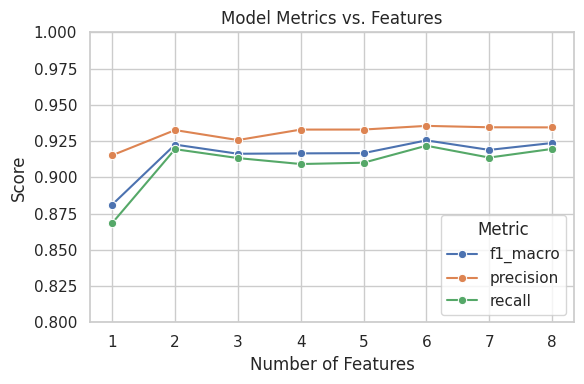

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.8, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [ ]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.922021,0.932665,0.917945
1,7,0.920364,0.931868,0.915842
2,6,0.916812,0.931629,0.910627
3,5,0.919109,0.931609,0.914054


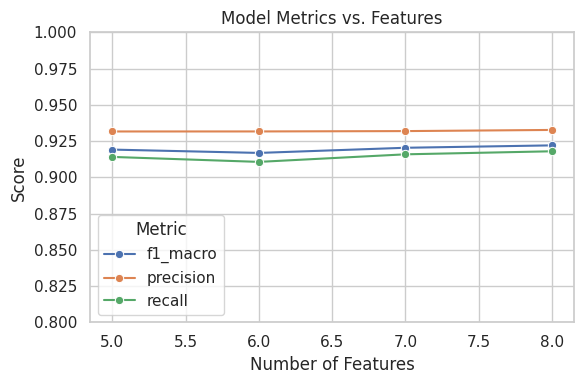

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.8, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## With E-PGExplainer

In [60]:
#PGExplainer 7 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

for num in range(8,3,-1):
  print(num)
  model = Model(num, 128, num, F.relu, 0.2).cuda()
  opt = th.optim.Adam(model.parameters())

  selected_features_per_class_r = {}
  for key in selected_features_per_class:
    selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
  for epoch in range(1,200):#200
      avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 4,selected_features_per_class_r)
      # train_losses.append(avg_loss)

  nfeats_test = G_test.ndata['feature']
  efeats_test = G_test.edata['h']
  actual = G_test.edata['label']
  predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

  report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

  df_ova_results.append(
      {
        'features': num,
        # 'acc': report['accuracy'],
        'f1_macro': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }
  )

  # del model
df_ova_results = pd.DataFrame(df_ova_results)
#todo append egraphsage / for all features ova


8


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor(weight, device=outputs.device))
/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to ru

7


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor(weight, device=outputs.device))
/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to ru

6


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor(weight, device=outputs.device))
/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to ru

5


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor(weight, device=outputs.device))
/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to ru

4


/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor(weight, device=outputs.device))
/jobfs/145254684.gadi-pbs/ipykernel_1803928/1520337698.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to ru

In [61]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.931766,0.940840,0.931268
1,7,0.931590,0.940485,0.931051
2,6,0.928572,0.936141,0.928341
3,5,0.923129,0.930727,0.924741
4,4,0.922147,0.932829,0.925013


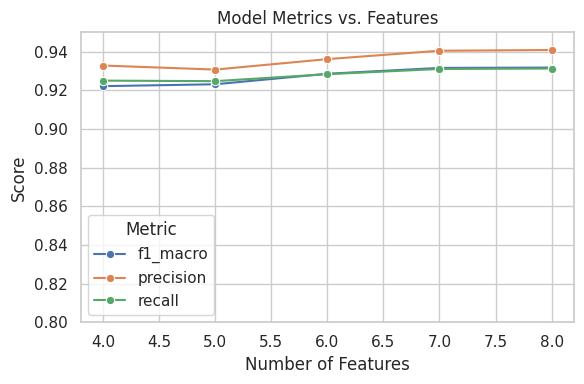

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.80, 0.95)
plt.legend(title='Metric')
plt.tight_layout()
# plt.savefig("/scratch/kc01/na3038/TrainedModels/plot.png")
plt.show()
#this is final result

In [159]:
df_ova_results #randomized

,features,f1_macro,precision,recall
0,8,0.925657,0.935186,0.922557
1,7,0.924697,0.935236,0.920497
2,6,0.903702,0.933550,0.890252
3,5,0.918007,0.926902,0.914970
4,4,0.927485,0.934251,0.927179


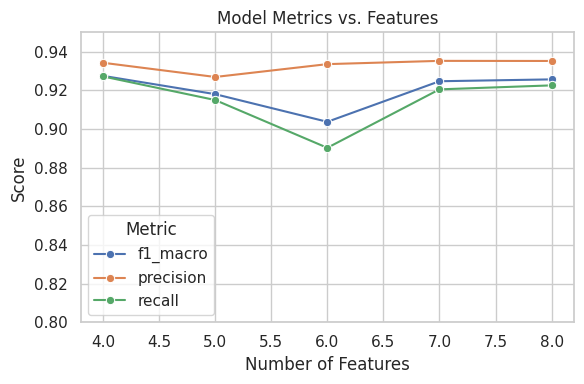

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.80, 0.95)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig("/scratch/kc01/na3038/TrainedModels/plot.png")
plt.show()

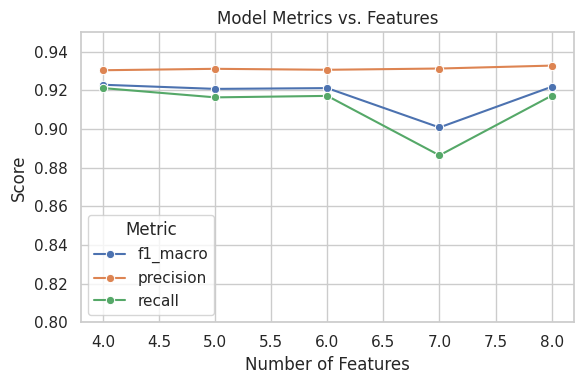

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.80, 0.95)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig("/scratch/kc01/na3038/TrainedModels/plot.png")
plt.show()

/jobfs/145257347.gadi-pbs/ipykernel_3992057/1520337698.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor(weight, device=outputs.device))
/jobfs/145257347.gadi-pbs/ipykernel_3992057/1520337698.py:18: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to ru

0.10732835438102484
0.09734665881842375
0.0955192232504487
0.09314678097143769
0.09036049945279956
0.08842624817043543
0.08950390107929707
157.0278011644259 seconds


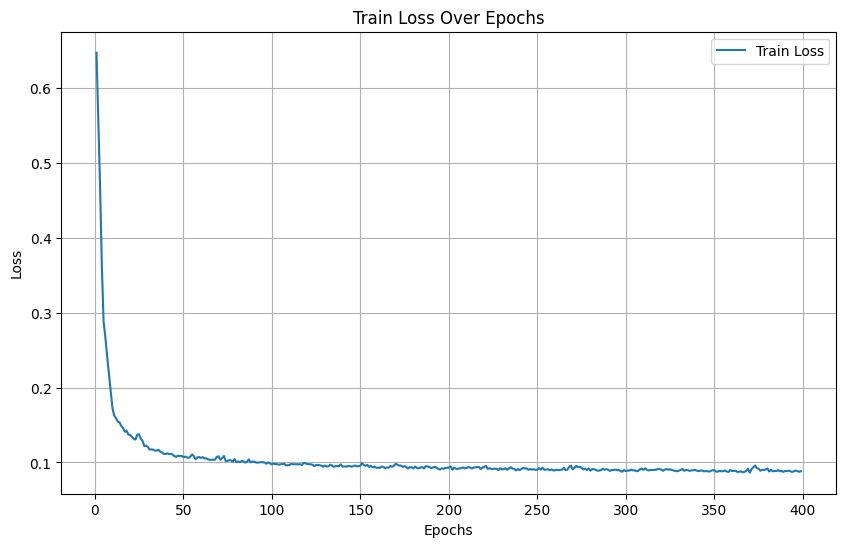

In [37]:
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

num=8
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

start_time = timeit.default_timer()

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

train_losses = []
for epoch in range(1,400):#200
  avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 4,selected_features_per_class_r)
  train_losses.append(avg_loss)
  if epoch % 50 ==0:
      print(avg_loss)

elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

epochs = range(1, 400)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
start_time = timeit.default_timer()
nfeats_test = G_test.ndata['feature']
efeats_test = G_test.edata['h']
# actual = G_test.edata['label']
predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)
elapsed = timeit.default_timer() - start_time
print(str(elapsed) + ' seconds')

# actual=le.inverse_transform(actual.cpu())
test_pred= le.inverse_transform(predicted_classes.squeeze().cpu())
report = classification_report(actual, test_pred, output_dict=True)

header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg']) #400 epoch

0.10082659870386124 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.8726    0.5069    0.6413    0.5069    8185      
DoS/DDoS       0.7774    0.9900    0.8709    0.9900    67978     
Reconnaissance 0.9824    0.9307    0.9559    0.9307    282778    
Theft          0.7801    0.5784    0.6643    0.5784    1110      

Overall Accuracy:
Accuracy: 0.9312

Weighted Averages:
{'precision': 0.9405707222942014, 'recall': 0.9311930809801945, 'f1-score': 0.9317716861199601, 'support': 360051.0}


In [25]:
# 0.09306836617179215 seconds #400 not randomized
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.8543    0.5080    0.6371    0.5080    8185      
# DoS/DDoS       0.7780    0.9902    0.8714    0.9902    67978     
# Reconnaissance 0.9826    0.9308    0.9560    0.9308    282778    
# Theft          0.7940    0.5694    0.6632    0.5694    1110      

# Overall Accuracy:
# Accuracy: 0.9313

# Weighted Averages:
# {'precision': 0.9404507738445824, 'recall': 0.9312680703566995, 'f1-score': 0.9318487123655874, 'support': 360051.0}
    
# 0.117254420183599 seconds - 400 randomized
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.7391    0.5006    0.5969    0.5006    8178      
# DoS/DDoS       0.7820    0.9800    0.8699    0.9800    68492     
# Reconnaissance 0.9820    0.9267    0.9535    0.9267    282248    
# Theft          0.1665    0.3380    0.2231    0.3380    1142      

# Overall Accuracy:
# Accuracy: 0.9253

# Weighted Averages:
# {'precision': 0.9358224704498279, 'recall': 0.9253152252402378, 'f1-score': 0.9272147369721423, 'support': 360060.0}
    
    # 0.10108992643654346 seconds - for 400 trained epoch results
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.7410    0.5014    0.5981    0.5014    8354      
# DoS            0.7744    0.9438    0.8507    0.9438    68468     
# Reconnaissance 0.9755    0.9269    0.9506    0.9269    282026    
# Theft          0.2779    0.6830    0.3951    0.6830    1202      

# Overall Accuracy:
# Accuracy: 0.9195

# Weighted Averages:
# {'precision': 0.9294592905854451, 'recall': 0.9194611859463964, 'f1-score': 0.9215671931399806, 'support': 360050.0}

# 0.09834042377769947 seconds - 600 epoch
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.3018    0.7223    0.4257    0.7223    8354      
# DoS            0.7768    0.9803    0.8667    0.9803    68468     
# Reconnaissance 0.9876    0.8842    0.9330    0.8842    282026    
# Theft          0.5859    0.5674    0.5765    0.5674    1202      

# Overall Accuracy:
# Accuracy: 0.8976

# Weighted Averages:
# {'precision': 0.9302684575596403, 'recall': 0.8976281072073323, 'f1-score': 0.907463928520066, 'support': 360050.0}

# 0.10279137548059225 seconds - 600 epoch with log class weights
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.9532    0.4634    0.6236    0.4634    8354      
# DoS            0.7781    0.9877    0.8705    0.9877    68468     
# Reconnaissance 0.9792    0.9325    0.9553    0.9325    282026    
# Theft          0.9165    0.3652    0.5223    0.3652    1202      

# Overall Accuracy:
# Accuracy: 0.9302

# Weighted Averages:
# {'precision': 0.9401089722608602, 'recall': 0.9302402444104986, 'f1-score': 0.930001043655209, 'support': 360050.0}

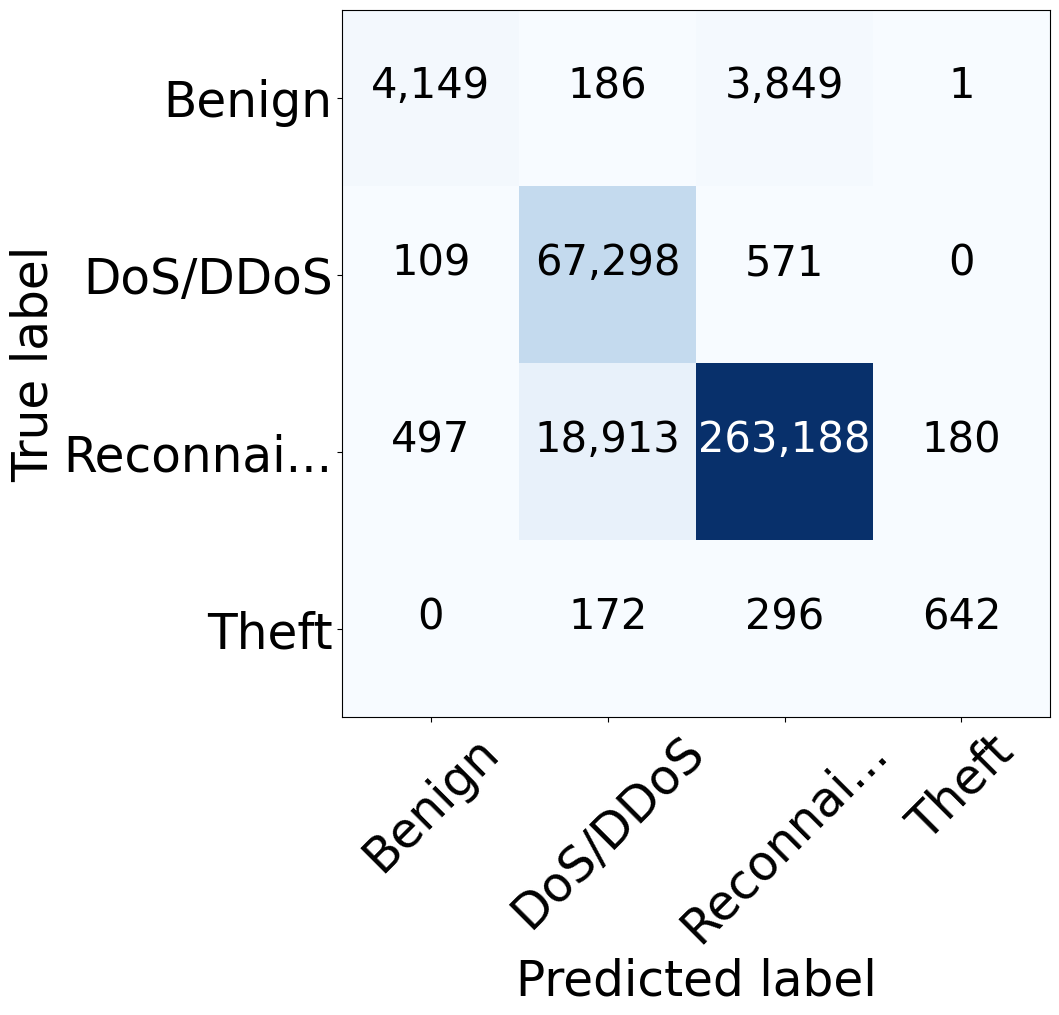

In [40]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=35,
                          text_fontsize=30):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8.5, 8.5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.savefig('/scratch/kc01/na3038/TrainedModels/proposed-cm.png',bbox_inches='tight')
    plt.show()
    
max_label_len = 8  # adjust as needed
target_names = np.unique(actual)
truncated_target_names = [
    f"{label[:max_label_len]}..." if len(label) > max_label_len else label
    for label in target_names
]
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = truncated_target_names,
                      # title        = "Confusion Matrix"
                      )

/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


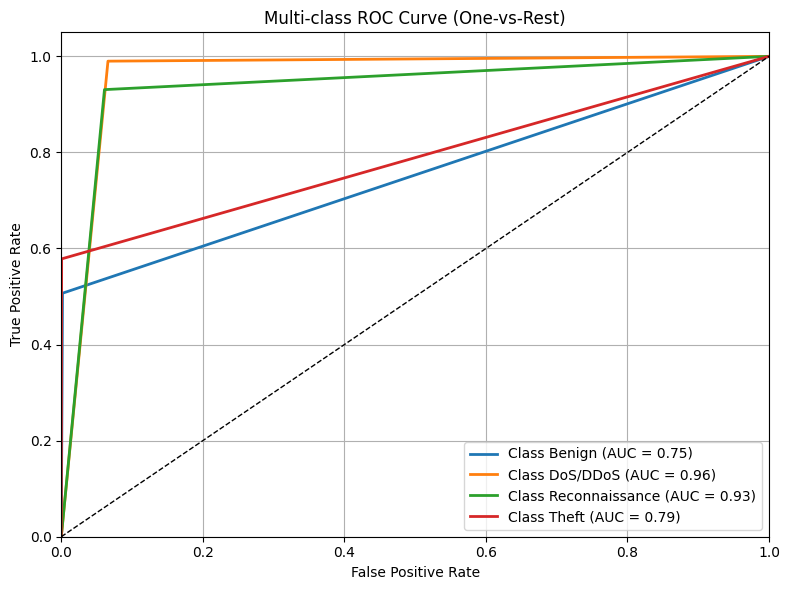

In [41]:
X = actual
y = le.inverse_transform(predicted_classes.cpu())
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Explain Dos/DDoS

In [ ]:
model.pred.classifiers[0]

Linear(in_features=256, out_features=1, bias=True)

In [ ]:
def predict_one_vs_all(model,graph,node_feat, edge_feat, class_indx):
    model.eval()

    with th.no_grad():
        # Forward pass to get binary classifier outputs for all classes
        outputs = model(graph, node_feat, edge_feat,class_idx=class_indx)
        outputs = th.sigmoid(outputs)
        predicted_classes = (outputs >= 0.50).int()

        # new_df=outputs.cpu().detach().numpy()
        # new_df=pd.DataFrame(outputs.squeeze().cpu())
        # print(outputs.squeeze().shape)
    #     predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes #, new_df

In [ ]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats, class_indx=1)
predicted_classes.unique()
# predict_one_vs_all(model,G_test, nfeats ,efeats, class_indx=0)

tensor([0, 1], device='cuda:0', dtype=torch.int32)

In [ ]:
binary_labels = (actual == 1).int()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(binary_labels, predicted_classes.cpu(), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
0              1.00      0.93      0.96      0.932     291868    
1              0.77      1.00      0.87      1.000     68192     

Overall Accuracy:
Accuracy: 0.94

Weighted Averages:
{'precision': 0.9571342597157868, 'recall': 0.9446120091095929, 'f1-score': 0.9471641349396115, 'support': 360060.0}


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_true = binary_labels.cpu().detach().numpy()
y_scores = predicted_classes.squeeze().cpu().detach().numpy()
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calculate AUC for Precision-Recall curve
pr_auc = auc(recall, precision)

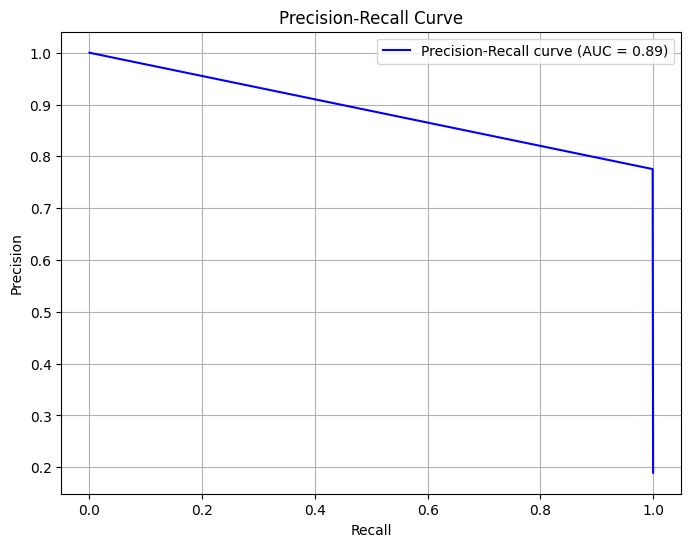

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# actual = le.inverse_transform(actual)
# test_pred = le.inverse_transform(predicted_classes)

dos_true_positives = []
for i in range(len(y_true)):
    if y_scores[i]==1 and y_scores[i] == y_true[i]:
      dos_true_positives.append(G_test.edata['Edge_indx'][i].cpu().item())

In [ ]:
len(true_positives)

68138

In [ ]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']

attack_edge_to_explain = 0 #initialize
attack_feature_array = {}
true_predicted_edge_indexes = random.sample(dos_true_positives, 10)
for edge_index in true_predicted_edge_indexes:
      attack_indices_list = (G_test.edata['Edge_indx'] == edge_index).nonzero(as_tuple=True)[0].to("cuda").tolist()
      if len(true_predicted_edge_indexes)>0:
        attack_edge_to_explain = attack_indices_list[0]
        attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats, class_idx=1)
        attack_feature_array[edge_index] = (attck_efeat_mask.cpu().detach().tolist())
lists = list(attack_feature_array.values())
averages = [sum(values) / len(values) for values in zip(*lists)]

feature_importance = {}
for i in range(8):
  feature_importance[cols_to_norm[i]]=averages[i]

del true_predicted_edge_indexes, attack_feature_array, lists, averages, feature_importance #, sorted_items
torch.cuda.empty_cache()
print(feature_importance)

KeyError: 'label'

# Local Explanations

### Benign

In [ ]:
attk_class = 'DoS'
print('Class type explaining:', attk_class)
# attack_edge_to_explain = 0 #initialize
# attack_feature_array = {}
true_predicted_benign_edge_index = 13 #random.sample(true_positives[attk_class], 1) #true_predicted_edge_index
true_predicted_benign_edge_index

Class type explaining: DoS


13

In [ ]:
attack_edge_to_explain = list((G_test.edata['Edge_indx'] == true_predicted_benign_edge_index).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]
attack_edge_to_explain

2

In [ ]:
attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats)
edge_feature_importance = (attck_efeat_mask.cpu().detach().tolist())

In [ ]:
feature_importance = {}
for i in range(8):
  feature_importance[cols_to_norm[i]]=edge_feature_importance[0][i]
sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_items:
  print(f'{key}: {value}')

OUT_BYTES: 0.8523483276367188
L7_PROTO: 0.8491301536560059
IN_BYTES: 0.737597644329071
TCP_FLAGS: 0.6260159611701965
OUT_PKTS: -0.5418569445610046
PROTOCOL: -0.6635388731956482
IN_PKTS: -0.7264429926872253
FLOW_DURATION_MILLISECONDS: -0.8527140617370605


In [ ]:
attck_efeat_sub_graph

Graph(num_nodes=167208, num_edges=56525,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
true_positives['DoS']

[0,
 0,
 13,
 18,
 30,
 41,
 63,
 66,
 82,
 111,
 166,
 189,
 191,
 198,
 212,
 224,
 242,
 267,
 275,
 282,
 289,
 290,
 307,
 326,
 328,
 332,
 346,
 355,
 384,
 391,
 399,
 406,
 425,
 430,
 431,
 441,
 446,
 468,
 479,
 500,
 515,
 519,
 533,
 537,
 565,
 569,
 598,
 629,
 635,
 642,
 651,
 671,
 684,
 728,
 769,
 778,
 779,
 802,
 811,
 814,
 843,
 881,
 896,
 917,
 926,
 941,
 958,
 985,
 1008,
 1010,
 1019,
 1028,
 1029,
 1046,
 1050,
 1058,
 1067,
 1068,
 1098,
 1111,
 1127,
 1129,
 1151,
 1162,
 1174,
 1175,
 1183,
 1209,
 1227,
 1232,
 1238,
 1248,
 1254,
 1266,
 1288,
 1297,
 1305,
 1312,
 1358,
 1367,
 1376,
 1377,
 1397,
 1398,
 1446,
 1452,
 1470,
 1471,
 1478,
 1479,
 1480,
 1505,
 1509,
 1537,
 1557,
 1558,
 1570,
 1582,
 1591,
 1594,
 1595,
 1648,
 1657,
 1671,
 1693,
 1696,
 1722,
 1724,
 1747,
 1761,
 1766,
 1767,
 1778,
 1779,
 1787,
 1811,
 1835,
 1843,
 1846,
 1854,
 1864,
 1869,
 1870,
 1873,
 1883,
 1890,
 1899,
 1948,
 1955,
 1963,
 1977,
 1978,
 1979,
 1982,
 

In [ ]:
num_hops = 2
source_node = G_test.edges()[0][2].item()
sg, inverse_indices = khop_in_subgraph(G_test, source_node, num_hops)
sg

Graph(num_nodes=14060, num_edges=28118,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
G_test.edges()

(tensor([100782, 188616, 188616,  ...,  34183,  81931, 178447], device='cuda:0'),
 tensor([188616, 100782, 179456,  ..., 184316, 185576, 185990], device='cuda:0'))

In [ ]:
G_test.nodes()

tensor([     0,      1,      2,  ..., 188815, 188816, 188817], device='cuda:0')

In [ ]:
G_test.edges()[0][2].item()

188616

In [ ]:
G_test.edata['Edge_indx']

tensor([     0,      0,     13,  ..., 180027, 180028, 180029], device='cuda:0')

In [ ]:
X_test.iloc[13]

,47083
IPV4_SRC_ADDR,172.30.88.50:58690
IPV4_DST_ADDR,192.168.100.7:80
PROTOCOL,0.257369
L7_PROTO,-1.665568
IN_BYTES,-0.018551
OUT_BYTES,-0.00641
IN_PKTS,-0.029746
OUT_PKTS,-0.007791
TCP_FLAGS,-1.381534
FLOW_DURATION_MILLISECONDS,0.487975


In [ ]:
X_test[X_test['IPV4_SRC_ADDR']=='172.30.88.50:58690']

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,Edge_indx,h
47083,172.30.88.50:58690,192.168.100.7:80,0.257369,-1.665568,-0.018551,-0.00641,-0.029746,-0.007791,-1.381534,0.487975,1,13,"[-0.006409981374379563, -0.007791121753422729,..."


In [ ]:
X_test[X_test.index==188616]

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,Edge_indx,h


In [ ]:
X_test.index.shape

NameError: name 'X_test' is not defined

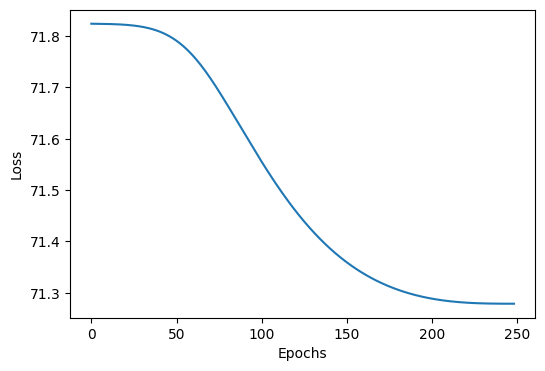

In [ ]:
attck_edge_indice, attck_sub_graph, attck_edge_mask, attck_loss = explain_edges(model, attack_edge_to_explain, G_test, nfeats, efeats,class_idx=1)

In [ ]:
attck_edge_mask.shape

torch.Size([28118])

In [ ]:
attck_sub_graph

Graph(num_nodes=14060, num_edges=28118,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
attck_edge_mask[attck_edge_mask > 0.8].unique()

tensor([0.8846, 0.8850, 0.8851,  ..., 0.8866, 0.8866, 0.8866], device='cuda:0')

In [ ]:
# edge_mask_intrusion_round = th.round(attck_edge_mask)
# unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
unwanted_1 = list((attck_edge_mask < 0.8866).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if attck_edge_indice in unwanted_1:
    unwanted_1.remove(attck_edge_indice)

In [ ]:
len(unwanted_1)

27284

In [ ]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

In [ ]:
g_intrusion

Graph(num_nodes=822, num_edges=834,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/g_intrusion.dgl"
save_graphs(file_path, g_intrusion)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
g_intrusion = loaded_graphs[0]

# Verify the loaded graph (optional)
print(g_intrusion)

Graph(num_nodes=822, num_edges=834,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64)})


In [ ]:
nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)
nx_graph_intrusion

In [ ]:
nx_graph_intrusion_Label = nx.get_edge_attributes(nx_graph_intrusion, "label")
keyss = list(nx_graph_intrusion_Label.keys())
valuess = list(nx_graph_intrusion_Label.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = valuess[indx].item()

In [ ]:
edge_labelss

{(0, 821): 1,
 (2, 821): 1,
 (3, 821): 1,
 (4, 821): 1,
 (6, 821): 1,
 (7, 821): 1,
 (10, 821): 1,
 (12, 821): 1,
 (16, 821): 1,
 (17, 821): 1,
 (18, 821): 1,
 (19, 821): 1,
 (21, 821): 1,
 (22, 821): 1,
 (25, 821): 1,
 (26, 821): 1,
 (27, 821): 1,
 (35, 821): 1,
 (37, 821): 1,
 (38, 821): 1,
 (42, 821): 1,
 (44, 821): 1,
 (45, 821): 1,
 (47, 821): 1,
 (49, 821): 1,
 (50, 821): 1,
 (51, 821): 1,
 (54, 821): 1,
 (55, 821): 1,
 (57, 821): 1,
 (58, 821): 1,
 (59, 821): 1,
 (60, 821): 1,
 (62, 821): 1,
 (65, 821): 1,
 (67, 821): 1,
 (68, 821): 1,
 (77, 821): 1,
 (79, 821): 1,
 (80, 821): 1,
 (82, 821): 1,
 (83, 821): 1,
 (85, 821): 1,
 (87, 821): 1,
 (91, 821): 1,
 (94, 821): 1,
 (98, 821): 1,
 (99, 821): 1,
 (100, 821): 1,
 (102, 821): 1,
 (104, 821): 1,
 (105, 821): 1,
 (106, 821): 1,
 (107, 821): 1,
 (115, 821): 1,
 (121, 821): 1,
 (122, 821): 1,
 (123, 821): 1,
 (124, 821): 1,
 (129, 821): 1,
 (133, 821): 1,
 (135, 821): 1,
 (136, 821): 1,
 (137, 821): 1,
 (139, 821): 1,
 (140, 821): 1

In [ ]:
# The explained edge
nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == attck_sub_graph.edata["Edge_indx"][attck_edge_indice].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])
orange_edge

(816, 821)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[200,200])
plt.title("Explanability of an intrusion edge")
pos = nx.circular_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
# nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

{(0, 821): Text(0.9999853977173365, -0.0038217437738610194, '1'),
 (2, 821): Text(0.9999269852330959, 0.0038212711629721507, '1'),
 (3, 821): Text(0.9998539386196477, 0.007642720248757007, '1'),
 (4, 821): Text(0.9997517172314798, 0.011463173665838156, '1'),
 (6, 821): Text(0.999459658164723, 0.019101115637356836, '1'),
 (7, 821): Text(0.9992698451691653, 0.022918401954895806, '1'),
 (10, 821): Text(0.9985254212288308, 0.0343594168580208, '1'),
 (12, 821): Text(0.9978834817612929, 0.041976817966890456, '1'),
 (16, 821): Text(0.996250706065509, 0.05717615072632154, '1'),
 (17, 821): Text(0.9957699469005079, 0.06096746094409444, '1'),
 (18, 821): Text(0.9952602615205075, 0.06475483630420409, '1'),
 (19, 821): Text(0.994721571344714, 0.06853921262622231, '1'),
 (21, 821): Text(0.9935575860053456, 0.07609368497975888, '1'),
 (22, 821): Text(0.9929323158743015, 0.0798639019985794, '1'),
 (25, 821): Text(0.9908838318613205, 0.09114539157141777, '1'),
 (26, 821): Text(0.9901436274171904, 0.09